In [1]:

import numpy as np
import sys
import os
import pandas as pd
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import itertools
from scipy import stats
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
def grouped_lineplot(df, x, y, hue, plot_marker=False, ymin=0, ymax=1, title=None, outfile=None, ci_estimator='mean'):
    fig, ax = plt.subplots(figsize=(12.5,7.5))

    g = sns.lineplot(x=x, y=y, hue=hue, data=df,
                       palette="cubehelix", estimator=ci_estimator, ax=ax)   

    sns.despine(ax=ax, left=True)
    ax.set_title(title,fontsize=24)
    ax.set_ylabel(y,fontsize=24)
    ax.set_xlabel('Order',fontsize=24)
    ax.set_ylim(ymin, ymax)
    
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[2], handles[3], handles[4]]
    labels = [labels[1], labels[2], labels[3], labels[4]]
    
    pieman_cs = ['intact', 'paragraph', 'word', 'rest']
    
    if plot_marker:
        for e, pc in enumerate(pieman_cs):
            pd_df = df[df['Condition']==pc]
            max_level = pd_df.groupby('Level').mean()[y]
            if type(plot_marker) is list:
                plt.plot(plot_marker[e], max_level[plot_marker[e]], marker='o', color='r', markersize=14)
            else:
                plt.plot(max_level.argmax(), max_level[max_level.argmax()], marker='o', color='r', markersize=14)

    
    l = ax.legend(handles,labels, loc='center left', bbox_to_anchor=(1.00, .65), ncol=1,fontsize=24)
    l._legend_box.align = "center"
    for line in l.get_lines():
        line.set_linewidth(4.0)
    ax.tick_params(labelsize=24)
    if not outfile:
        fig.show()
    else:
        fig.savefig(outfile, bbox_inches='tight')

In [3]:
def grouped_barplot(df, x, y, hue, ymin=0, ymax=1, title=None, outfile=None):
    fig, ax = plt.subplots(figsize=(12.5,7.5))
    g = sns.factorplot(x=x, y=y, hue=hue, data=df, kind="bar", estimator=np.mean, ci=95, n_boot=1000,
                       palette="cubehelix", ax=ax, order=['intact', 'paragraph', 'word', 'rest'])

    sns.despine(ax=ax, left=True)
    ax.set_title(title, fontsize=24)
    ax.set_ylabel(y, fontsize=24)
    ax.set_xlabel(x, fontsize=24)
    ax.set_ylim(ymin, ymax)

    l = ax.legend(loc='center', bbox_to_anchor=(1, .65), ncol=1, fontsize=24)
    l._legend_box.align = "center"
    l.set_title('Order',prop={'size':24})
    
    ax.tick_params(labelsize=24)
    if not outfile:
        fig.show()
    else:
        fig.savefig(outfile, bbox_inches='tight')

In [4]:
def average_param(params, conds):
    
    ave_data = pd.DataFrame()
    for e, con in enumerate(conds):

        for p in params:

            param_name = os.path.basename(os.path.splitext(p)[0])
            full_data = combine_param_df(p)

            p_df = full_data[full_data['Condition']==con]
            ave_rel_level = p_df.groupby(['Level', 'Condition']).mean()['Relative accuracy']
            ave_z_level = p_df.groupby(['Level', 'Condition']).mean()['Z accuracy']
            ave_norm_level = p_df.groupby(['Level', 'Condition']).mean()['Normalized accuracy']
            
            
            p_split = param_name.split('_')

            ave_rel_df = ave_rel_level.to_frame().reset_index()
            ave_z_df = ave_z_level.to_frame().reset_index()
            ave_norm_df = ave_norm_level.to_frame().reset_index()
            
            sum_data = pd.DataFrame({'Relative accuracy': ave_rel_df['Relative accuracy'],'Z accuracy': ave_z_df['Z accuracy'], 'Normalized accuracy': ave_norm_df['Normalized accuracy'],'Level': ave_rel_df['Level'], 'Condition': ave_rel_df['Condition'], 'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])})

            if ave_data.empty:
                ave_data = sum_data
            else:
                ave_data = ave_data.append(sum_data)
                
    return ave_data
            

In [21]:
def average_param_ttest(params, conds):
    
    ave_data = pd.DataFrame()
    for e, con in enumerate(conds):

        for p in params:

            param_name = os.path.basename(os.path.splitext(p)[0])
            full_data = combine_param_df(p)

            p_df = full_data[full_data['Condition']==con]
            ave_rel_level = p_df.groupby(['Level', 'Condition']).mean()['Relative accuracy']
            ave_z_level = p_df.groupby(['Level', 'Condition']).mean()['Z accuracy']
            ave_norm_level = p_df.groupby(['Level', 'Condition']).mean()['Normalized accuracy']
            
            print(ttest_ind(*p_df.groupby('Level')['Condition'].apply(lambda x:list(x))))

            p_split = param_name.split('_')

            ave_rel_df = ave_rel_level.to_frame().reset_index()
            ave_z_df = ave_z_level.to_frame().reset_index()
            ave_norm_df = ave_norm_level.to_frame().reset_index()
            
            sum_data = pd.DataFrame({'Relative accuracy': ave_rel_df['Relative accuracy'],'Z accuracy': ave_z_df['Z accuracy'], 'Normalized accuracy': ave_norm_df['Normalized accuracy'],'Level': ave_rel_df['Level'], 'Condition': ave_rel_df['Condition'], 'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])})

            if ave_data.empty:
                ave_data = sum_data
            else:
                ave_data = ave_data.append(sum_data)
                
    return ave_data
            

In [5]:
def combine_param_df(params):
    param_name = os.path.basename(os.path.splitext(params)[0])

    conds =glob.glob(os.path.join(params, '*.csv'))

    full_data = pd.DataFrame()
    for c in conds:

        cond_name = os.path.basename(os.path.splitext(c)[0])
        chance = 1/300      
        if cond_name == 'paragraph':
            chance = 1/272
        elif cond_name == 'rest':
            chance = 1/400

        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0])
        data['Relative accuracy'] = data['accuracy'] - chance
        data['Normalized accuracy']= data['accuracy'] - np.min(data.groupby('level')['accuracy'].mean())
        data['Normalized accuracy'] = data['Normalized accuracy'] / np.max(data.groupby('level')['Normalized accuracy'].mean())
        data['Z accuracy']= (data['accuracy'] - data['accuracy'].mean())/data['accuracy'].std()

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    full_data = full_data.rename(index=str, columns={"level": "Level", "accuracy": "Accuracy", "condition": "Condition"})

    return full_data

In [6]:
def max_level_bycolumn(ave_df, y='Relative accuracy'):
    
    pieman_cs = ['intact', 'paragraph', 'word', 'rest']
    
    max_lev = []
    for e, pc in enumerate(pieman_cs):
        pd_df = ave_df[ave_df['Condition']==pc]
        max_lev.append(pd_df.groupby('Level').mean()[y].argmax())
    
    return max_lev
        
    

In [7]:
figdir = '../figs'
if not os.path.isdir(figdir):
    os.mkdir(figdir)

In [8]:
results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')

In [9]:
analysis_name = 'level_analysis_optimized_param_search'

In [10]:
data_dir = os.path.join(results_dir, analysis_name)

In [11]:
pieman_params =glob.glob(os.path.join(data_dir, '*'))

In [12]:
pieman_params

['/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_10',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_20',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_5',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_50',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_laplace_10',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_laplace_20',
 '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/level_analysis_optimized_param_search/is

## Plot correlation of level and accuracy by parameters

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:18: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


<Figure size 396x324 with 0 Axes>

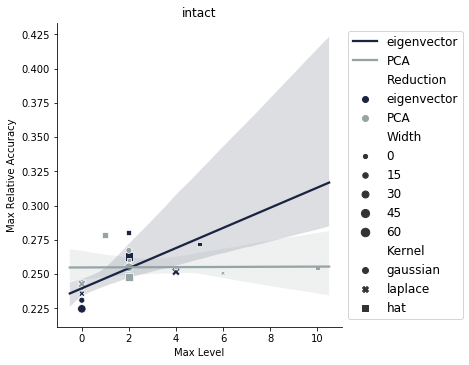

<Figure size 396x324 with 0 Axes>

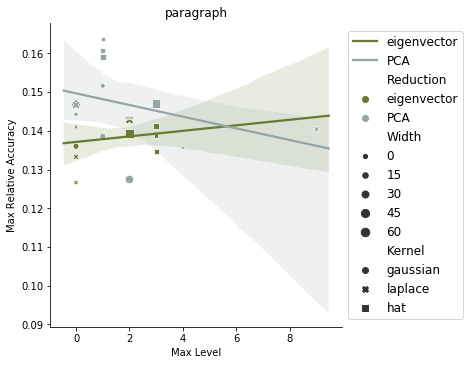

<Figure size 396x324 with 0 Axes>

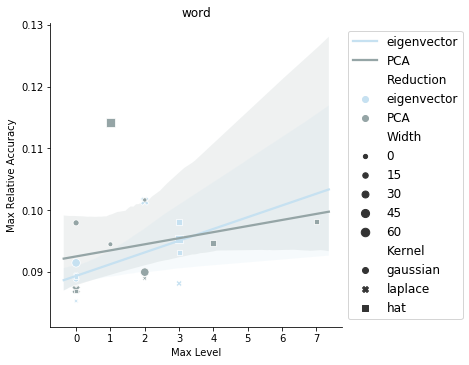

<Figure size 396x324 with 0 Axes>

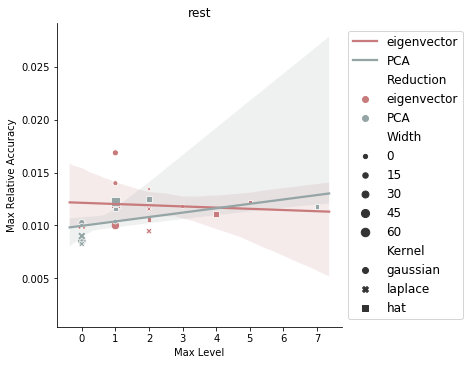

In [13]:
color_order = [0, 2, 5, 3]
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

for e, con in enumerate(pieman_conds):

    all_data = pd.DataFrame()
    
    for p in pieman_params:
        
        param_name = os.path.basename(os.path.splitext(p)[0])
        full_data = combine_param_df(p)
        
        p_df = full_data[full_data['Condition']==con]
        max_level = p_df.groupby('Level').mean()['Relative accuracy']

        p_split = param_name.split('_')

        sum_data = pd.DataFrame({'Max Relative Accuracy': max_level[max_level.argmax()], 'Max Level': max_level.argmax(), 'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])}, index=[0])

        if all_data.empty:
            all_data = sum_data
        else:
            all_data = all_data.append(sum_data)
    
               
    fig= plt.figure(figsize=(5.5,4.5))
    ax = sns.lmplot(x = 'Max Level', y = 'Max Relative Accuracy' , hue = 'Reduction',palette = dict(eigenvector=sns.color_palette("cubehelix")[color_order[e]], PCA="#95a5a6"), scatter=False, legend=False, data = all_data)
    sns.scatterplot(x = 'Max Level', y = 'Max Relative Accuracy' , hue = 'Reduction', style = 'Kernel', size = 'Width', palette = dict(eigenvector=sns.color_palette("cubehelix")[color_order[e]], PCA="#95a5a6"),data = all_data)
    plt.legend(loc='center left', bbox_to_anchor=(1.00, .5), ncol=1,fontsize=12)
    plt.title(con)

## Plot average across all parameters

In [117]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

all_data = average_param(pieman_params, pieman_conds)

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


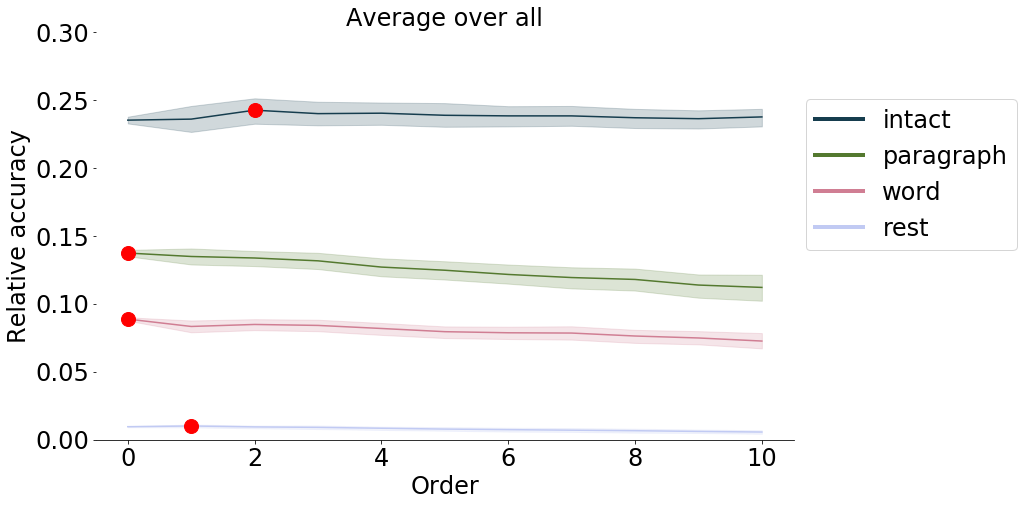

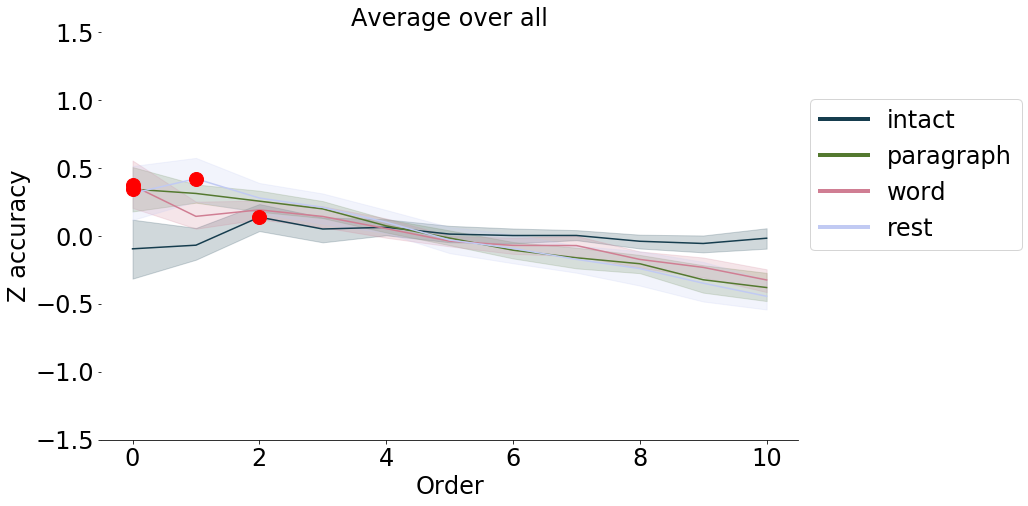

In [118]:
#outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
outfile=None
grouped_lineplot(all_data, 'Level', 'Relative accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = 'Average over all', outfile=outfile)
plt.show()
plt.close()
               
grouped_lineplot(all_data, 'Level', 'Z accuracy','Condition', plot_marker=True, ymin=-1.5, ymax=1.5, title = 'Average over all', outfile=outfile)
plt.show()
plt.close()

## Plot average across kernel type

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


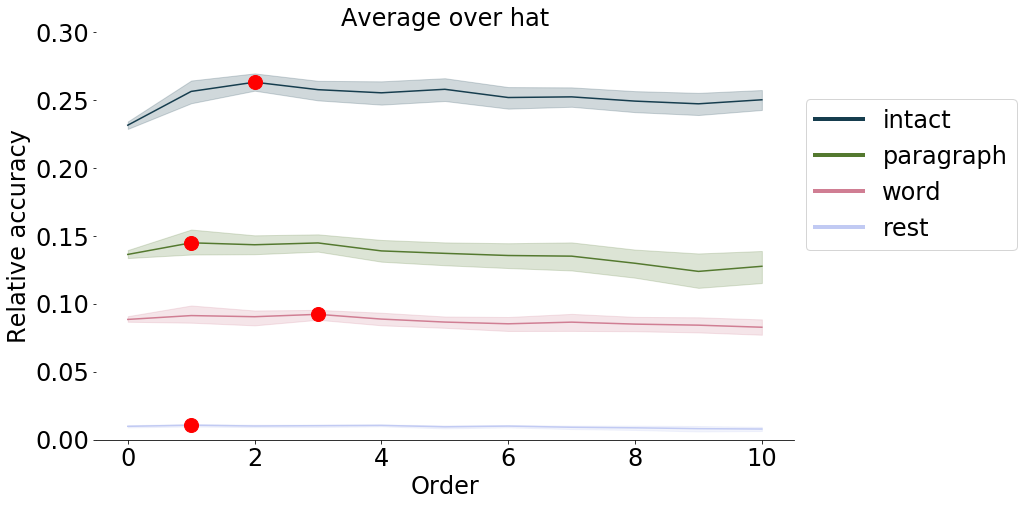

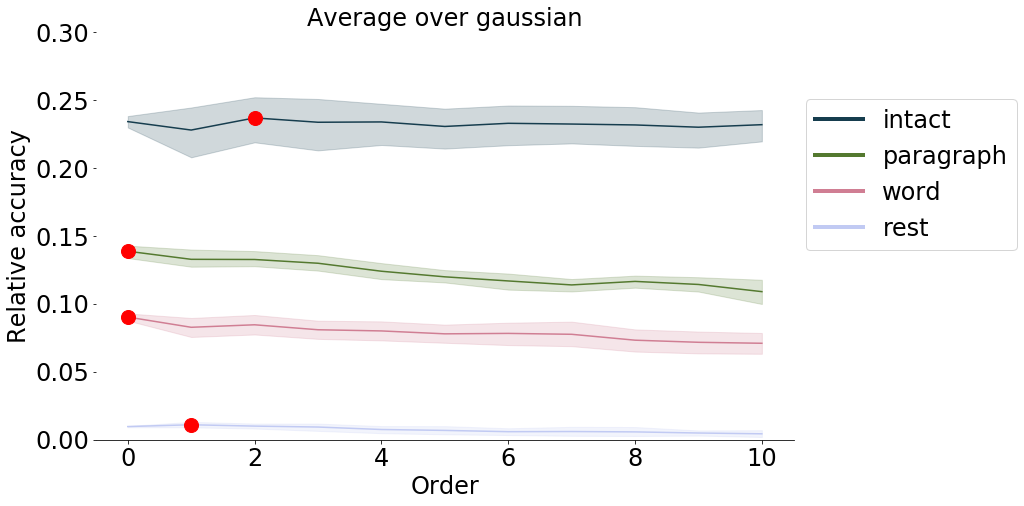

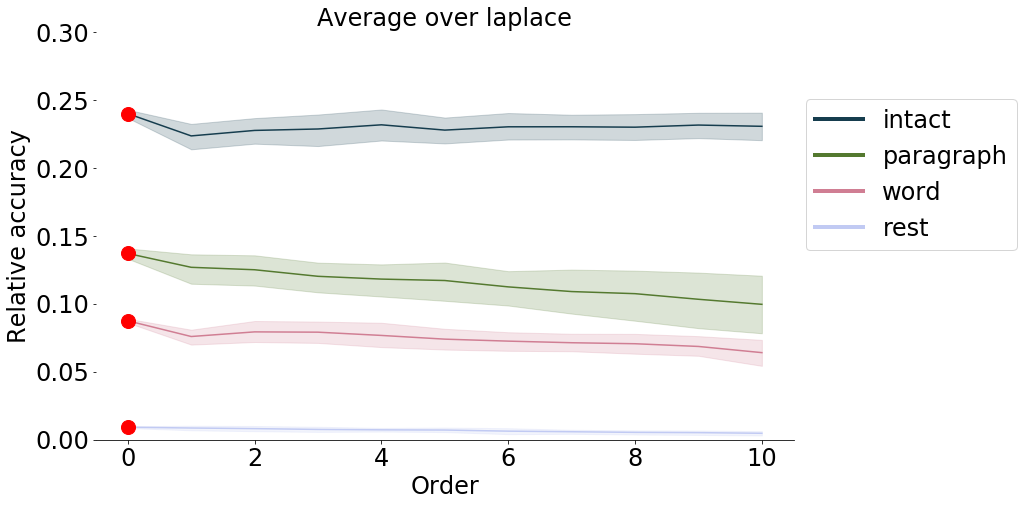

In [15]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']
Reduction_type = ['PCA', 'eigenvector']
Kernel_type = ['hat', 'gaussian', 'laplace']

split_by = 'Kernel'

for i in eval(split_by + '_type'):

    #outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
    outfile=None
    grouped_lineplot(all_data[all_data[split_by]==i], 'Level', 'Relative accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = 'Average over ' + i, outfile=outfile)
    plt.show()
    plt.close()
               

## Plot average across reduction type

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


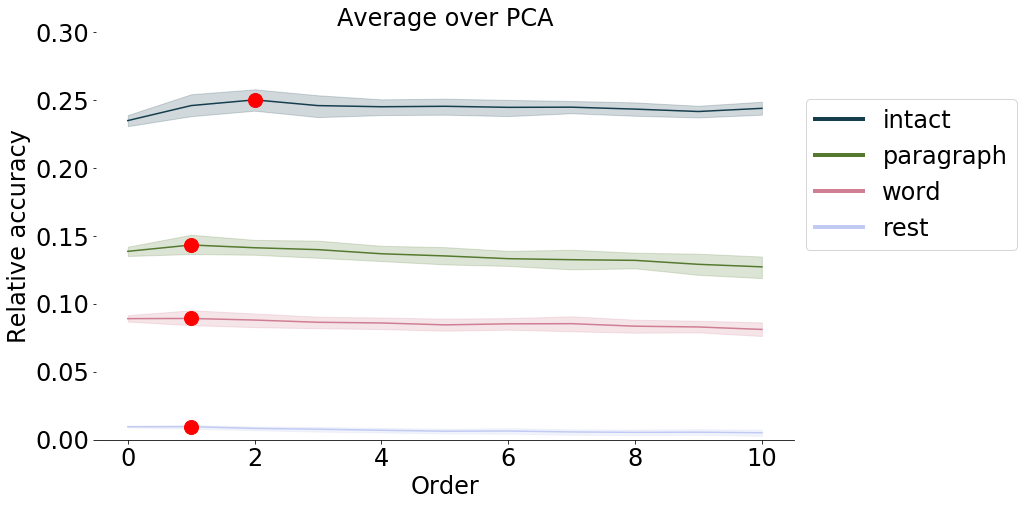

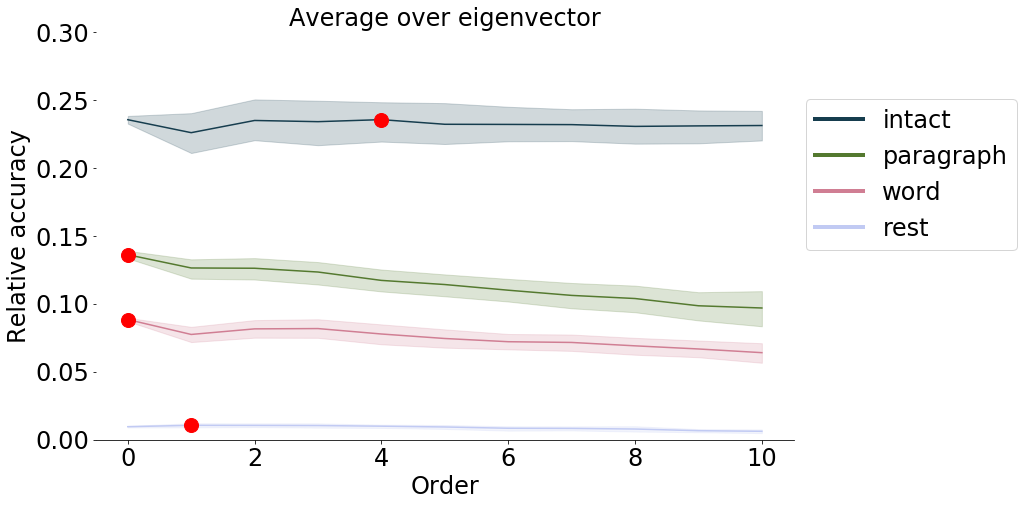

In [19]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']
Reduction_type = ['PCA', 'eigenvector']
Kernel_type = ['hat', 'gaussian', 'laplace']
Width_type = [5, 10, 20, 50]

split_by = 'Reduction'

for i in eval(split_by + '_type'):
       
    #outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
    outfile=None
    grouped_lineplot(all_data[all_data[split_by]==i], 'Level', 'Relative accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = 'Average over ' + i, outfile=outfile)
    plt.show()
    plt.close()

In [149]:
all_data

Relative accuracy  Z accuracy  Normalized accuracy  Level Condition  \
0            0.242167    0.426507         1.000000e+00      0    intact   
1            0.221333   -0.227280         1.287859e-15      1    intact   
2            0.229833    0.039465         4.080000e-01      2    intact   
3            0.224667   -0.122674         1.600000e-01      3    intact   
4            0.228833    0.008083         3.600000e-01      4    intact   
5            0.222833   -0.180208         7.200000e-02      5    intact   
6            0.223167   -0.169747         8.800000e-02      6    intact   
7            0.227667   -0.028529         3.040000e-01      7    intact   
8            0.230500    0.060386         4.400000e-01      8    intact   
9            0.232667    0.128380         5.440000e-01      9    intact   
10           0.230667    0.065617         4.480000e-01     10    intact   
0            0.230952    0.344703         1.000000e+00      0    intact   
1            0.215238   -0.212657        -2.109424e-15      1    intact   
2            0.223333    0.074468         5.151515e-01      2    intact   
3            0.223810    0.091358         5.454545e-01      3    intact   
4            0.219048   -0.077539         2.424242e-01      4    intact   
5            0.220000   -0.043760         3.030303e-01      5    intact   
6            0.222857    0.057579         4.848485e-01      6    intact   
7            0.220476   -0.026870         3.333333e-01      7    intact   
8            0.217143   -0.145098         1.212121e-01      8    intact   
9            0.221429    0.006909         3.939394e-01      9    intact   
10           0.219286   -0.069094         2.575758e-01     10    intact   
0            0.236458    0.238674         1.000000e+00      0    intact   
1            0.217708   -0.334839         9.367507e-16      1    intact   
2            0.226458   -0.067200         4.666667e-01      2    intact   
3            0.227292   -0.041710         5.111111e-01      3    intact   
4            0.231458    0.085737         7.333333e-01      4    intact   
5            0.226458   -0.067200         4.666667e-01      5    intact   
6            0.231250    0.079365         7.222222e-01      6    intact   
7            0.228750    0.002897         5.888889e-01      7    intact   
..                ...         ...                  ...    ...       ...   
3            0.011875    0.116471         6.923077e-01      3      rest   
4            0.011250   -0.034256         3.846154e-01      4      rest   
5            0.011094   -0.071938         3.076923e-01      5      rest   
6            0.011250   -0.034256         3.846154e-01      6      rest   
7            0.011250   -0.034256         3.846154e-01      7      rest   
8            0.011094   -0.071938         3.076923e-01      8      rest   
9            0.011406    0.003426         4.615385e-01      9      rest   
10           0.011094   -0.071938         3.076923e-01     10      rest   
0            0.011250    0.525227         9.607843e-01      0      rest   
1            0.011528    0.578722         1.000000e+00      1      rest   
2            0.009167    0.124012         6.666667e-01      2      rest   
3            0.011111    0.498479         9.411765e-01      3      rest   
4            0.009444    0.177507         7.058824e-01      4      rest   
5            0.008611    0.017021         5.882353e-01      5      rest   
6            0.010000    0.284498         7.843137e-01      6      rest   
7            0.007361   -0.223708         4.117647e-01      7      rest   
8            0.004722   -0.731914         3.921569e-02      8      rest   
9            0.004444   -0.785409        -2.035409e-16      9      rest   
10           0.006111   -0.464437         2.352941e-01     10      rest   
0            0.009000   -0.307532         6.661338e-17      0      rest   
1            0.012250    0.463996         1.000000e+00      1      rest   
2            0.010750    0.10

## Calculate stats and plot for eigenvector 

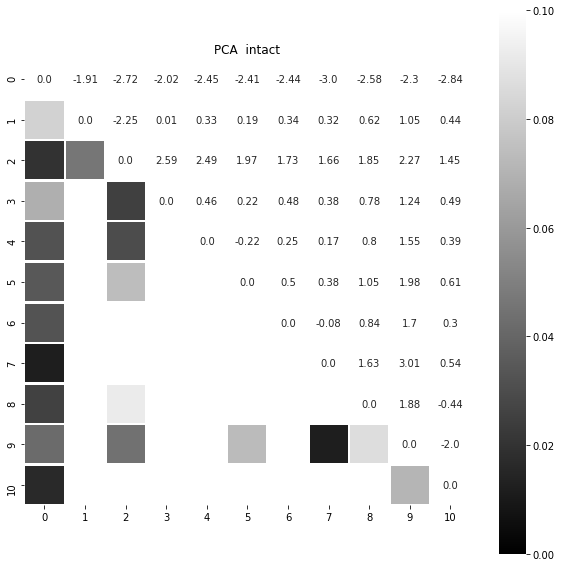

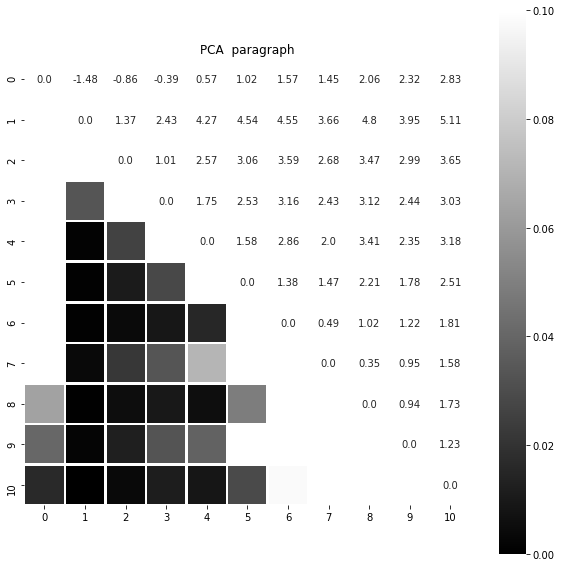

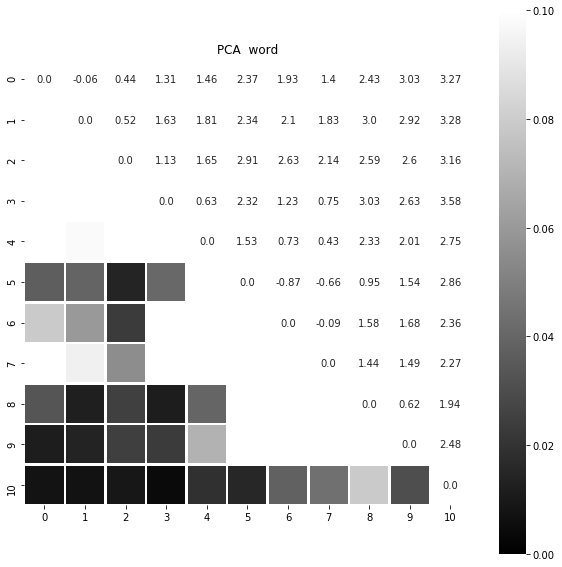

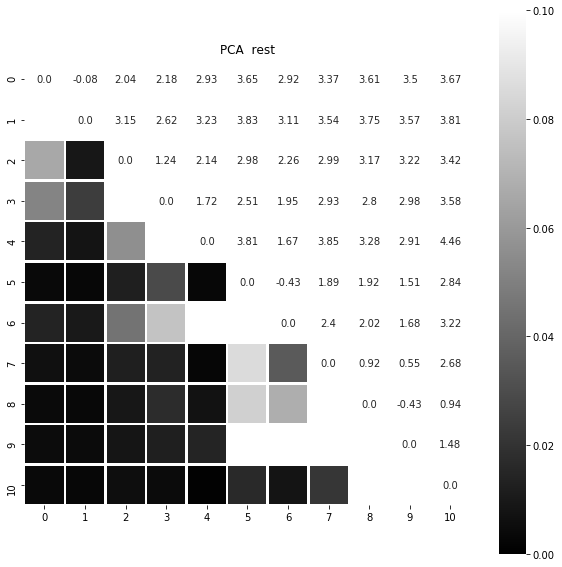

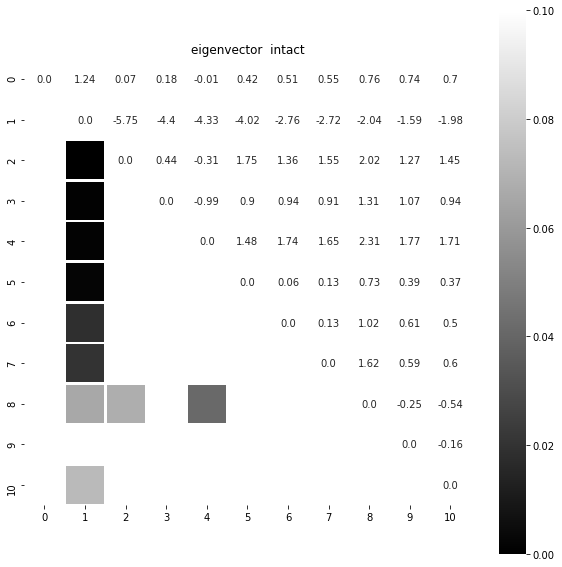

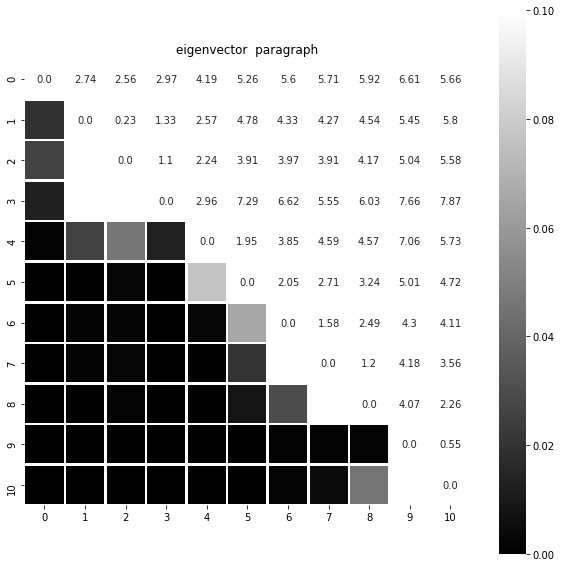

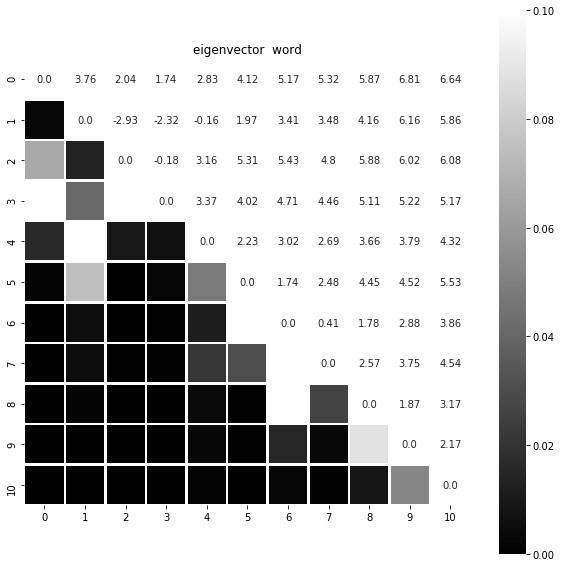

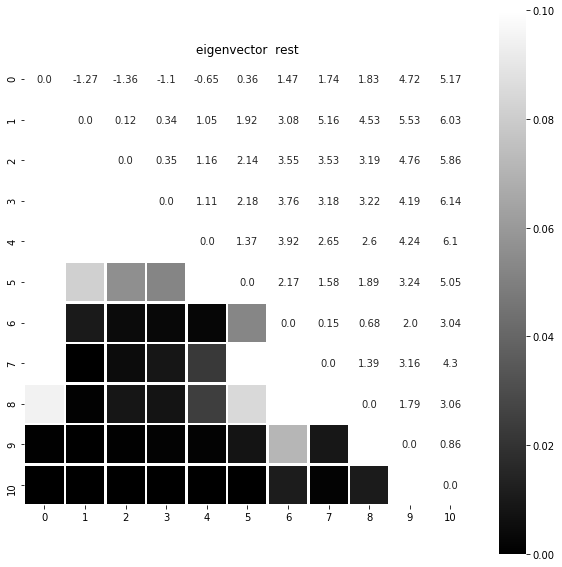

In [131]:
lev_perms = list(range(11))
lev_perms
stat_dict = {}


split_by = 'Reduction'

for i in eval(split_by + '_type'):

    t_array = np.zeros((11, 11, 4))
    
    for e, c in enumerate(pieman_conds):

        parsed_pd = all_data[(all_data['Condition']==c)&(all_data['Reduction']==i)]

        for pair in list(itertools.combinations(lev_perms, r=2)):

            t = stats.ttest_rel(parsed_pd[parsed_pd['Level']==pair[0]]['Relative accuracy'], 
                                parsed_pd[parsed_pd['Level']==pair[1]]['Relative accuracy'])

            t_array[pair[0], pair[1], e] = t.statistic
            t_array[pair[1], pair[0], e] = t.pvalue

        fig, ax = plt.subplots(figsize=(10,10)) 
        arr_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        data = t_array[:, :, e]
        df = pd.DataFrame(data, columns=arr_name)
        labels = df.where(np.triu(np.ones(df.shape)).astype(np.bool))
        labels = labels.round(2)
        labels = labels.replace(np.nan,' ', regex=True)

        mask = np.triu(np.ones(df.shape)).astype(np.bool)
        ax = sns.heatmap(df, mask=mask, cmap='binary_r', fmt='', square=True, linewidths=1.5, vmin=0, vmax=.1, ax=ax)
        mask = np.ones((11, 11))-mask
        ax = sns.heatmap(df, mask=mask, cmap=ListedColormap(['white']),annot=labels,cbar=False, fmt='', linewidths=1.5, ax=ax)
        ax.set_title(i + '  ' + c)
        plt.show()

## Make plots

In [121]:
split_by = 'Reduction'

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


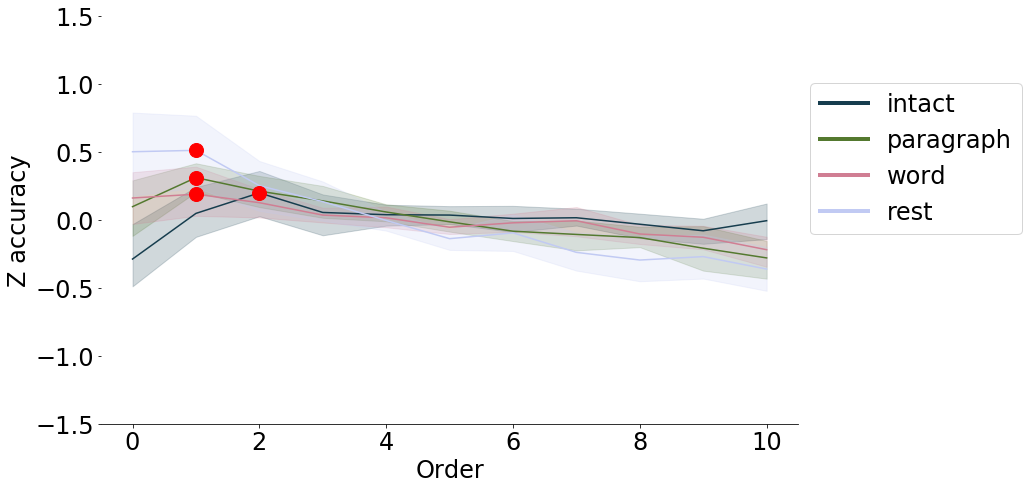

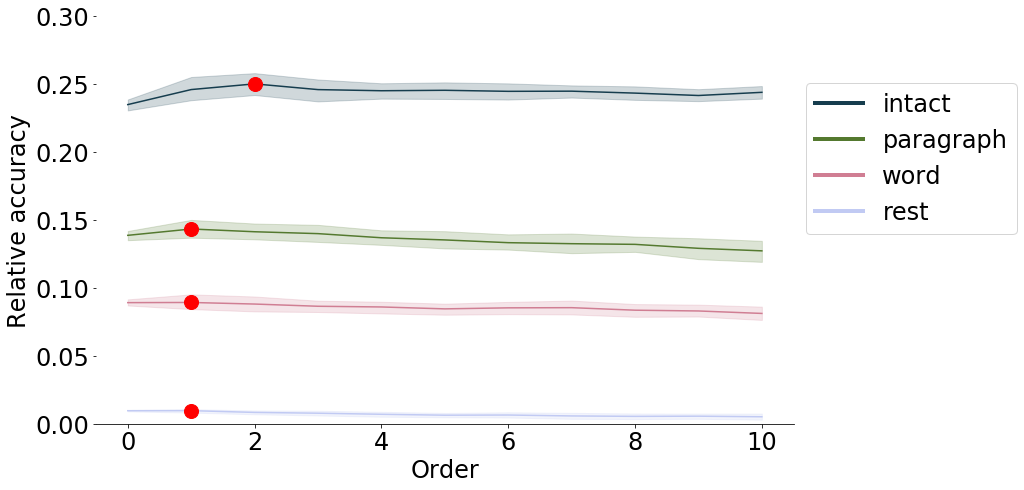

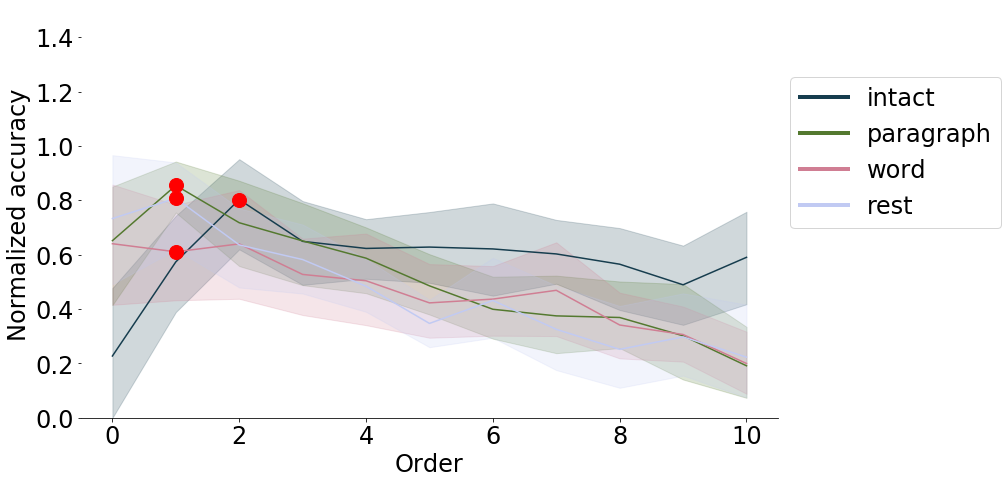

In [122]:
reduction_type = 'PCA'

all_data = average_param(pieman_params, pieman_conds)

markers_y = max_level_bycolumn(all_data[all_data[split_by]==reduction_type], y='Relative accuracy')

outfile = os.path.join(figdir, reduction_type + '_z_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Z accuracy','Condition', plot_marker=markers_y, ymin=-1.5, ymax=1.5, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_rel_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Relative accuracy','Condition', plot_marker=markers_y, ymin=0, ymax=.3, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_norm_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Normalized accuracy','Condition', plot_marker=markers_y, ymin=0, ymax=1.5, title = '', outfile=outfile)
plt.show()
plt.close()

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


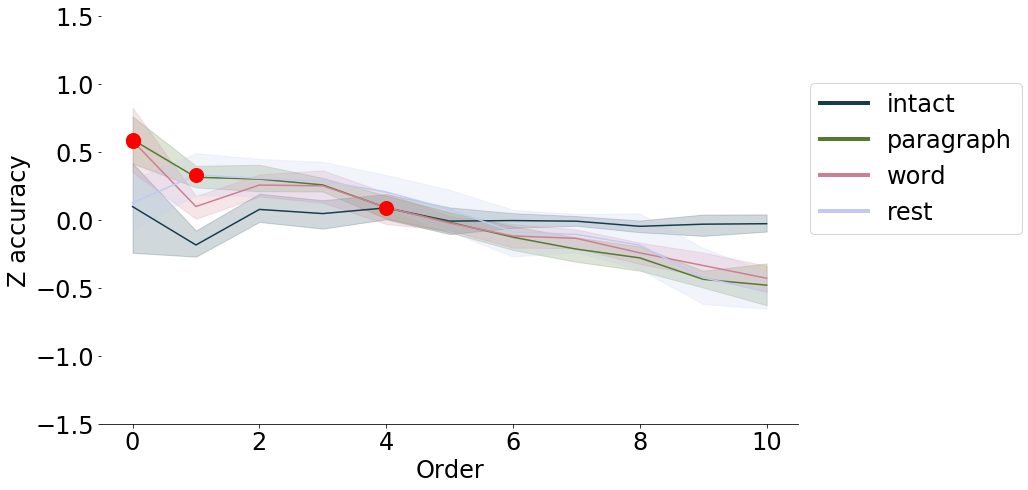

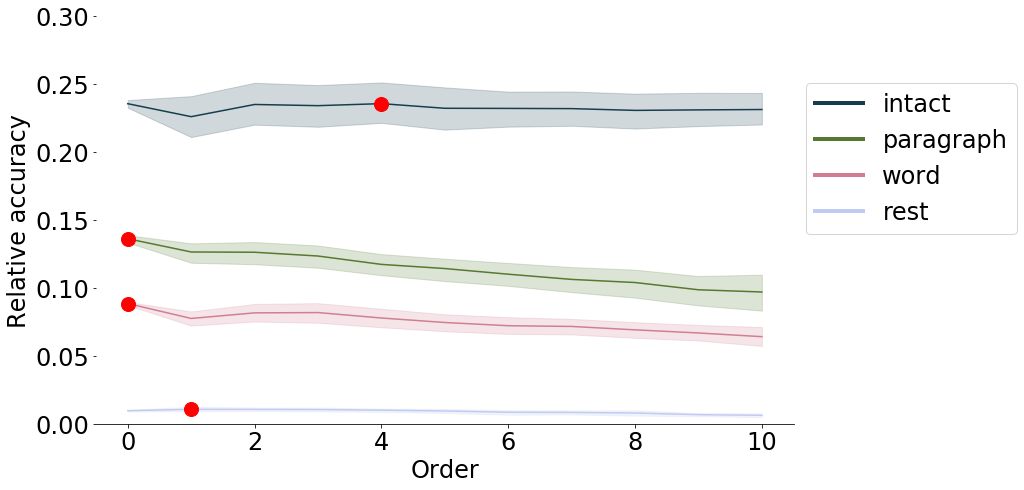

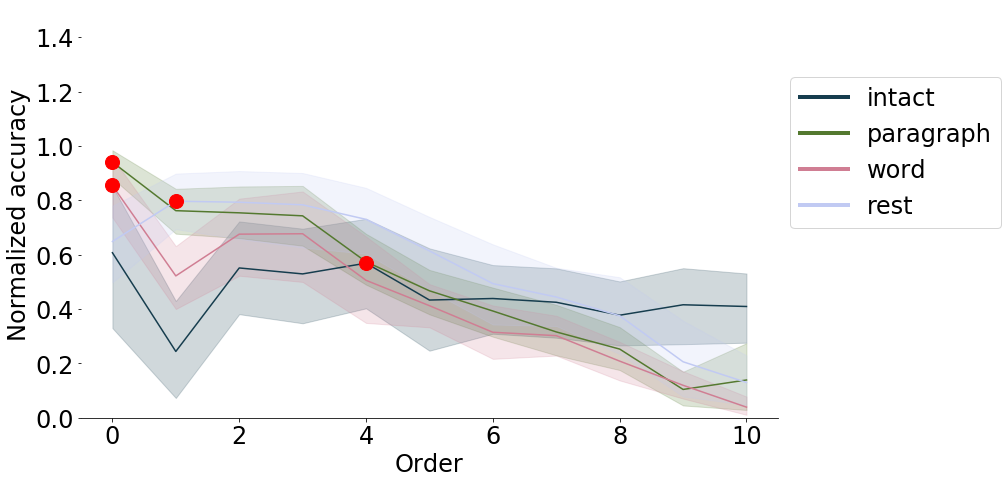

In [123]:
reduction_type = 'eigenvector'

all_data = average_param(pieman_params, pieman_conds)

markers_y = max_level_bycolumn(all_data[all_data[split_by]==reduction_type], y='Relative accuracy')

outfile = os.path.join(figdir, reduction_type + '_z_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Z accuracy','Condition', plot_marker=markers_y, ymin=-1.5, ymax=1.5, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_rel_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Relative accuracy','Condition', plot_marker=markers_y, ymin=0, ymax=.3, title = '', outfile=outfile)
plt.show()
plt.close()

outfile = os.path.join(figdir, reduction_type + '_norm_ave_'+ analysis_name + '.pdf')
grouped_lineplot(all_data[all_data[split_by]==reduction_type], 'Level', 'Normalized accuracy','Condition', plot_marker=markers_y, ymin=0, ymax=1.5, title = '', outfile=outfile)
plt.show()
plt.close()

## Plot average across width

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


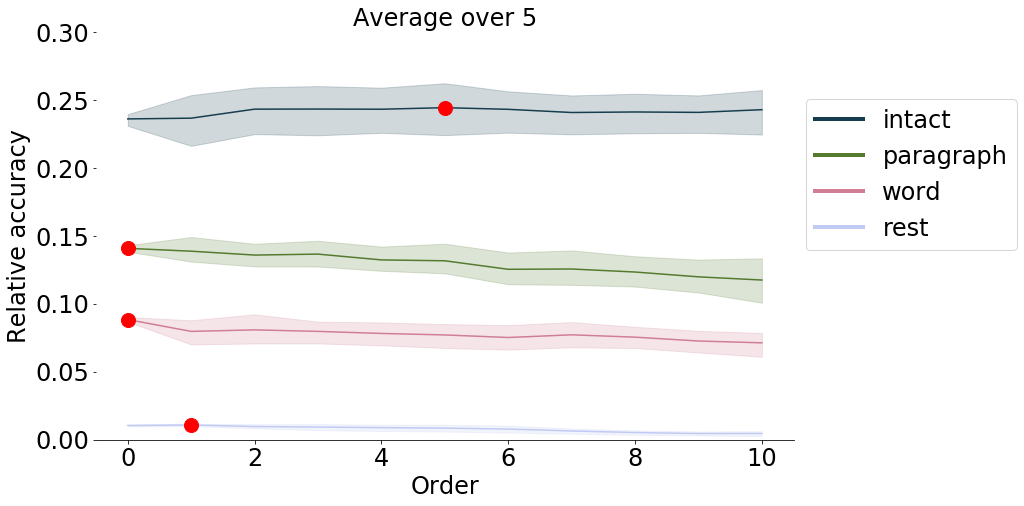

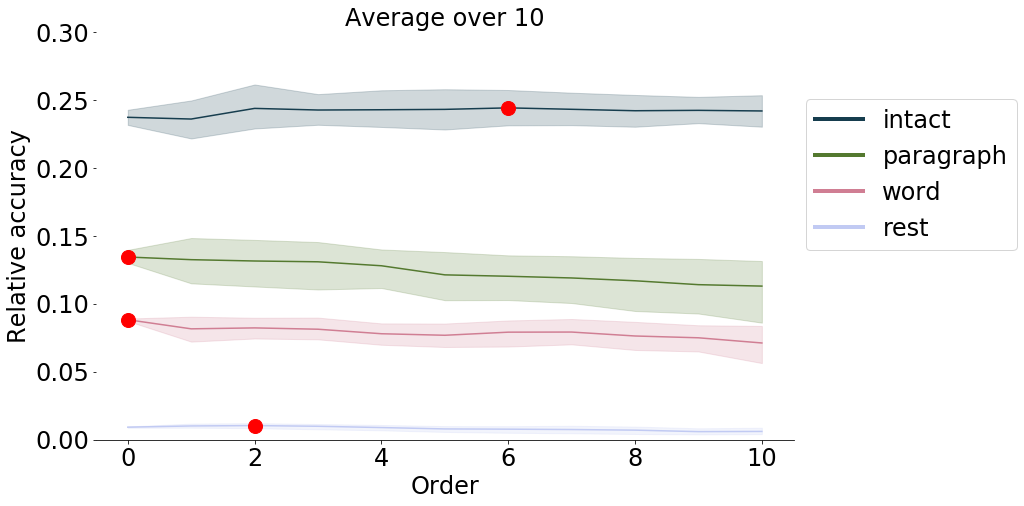

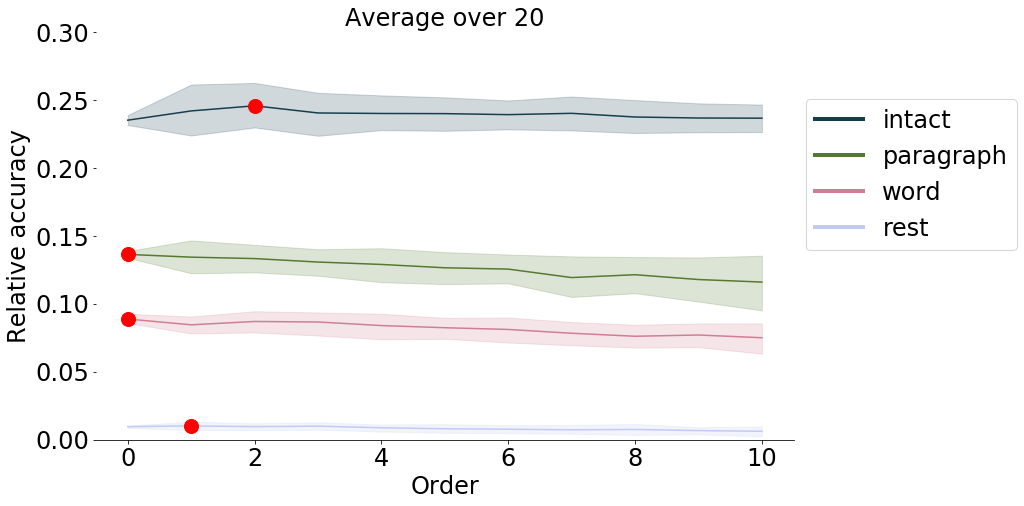

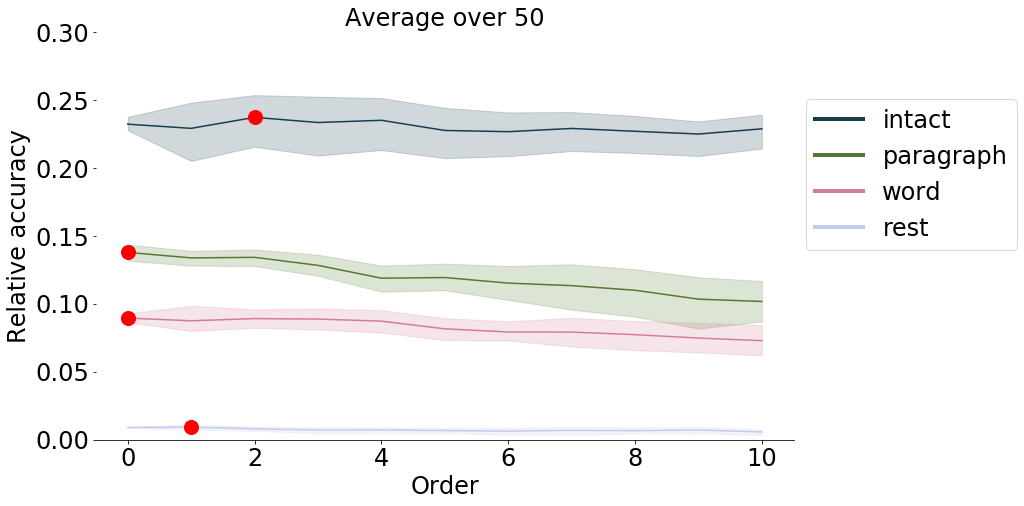

In [23]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']
Reduction_type = ['PCA', 'eigenvector']
Kernel_type = ['hat', 'gaussian', 'laplace']
Width_type = [5, 10, 20, 50]

split_by = 'Width'

all_data = average_param(pieman_params, pieman_conds)
    
for i in eval(split_by + '_type'):
            
    #outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
    outfile=None
    grouped_lineplot(all_data[all_data[split_by]==i], 'Level', 'Relative accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = 'Average over ' + str(i), outfile=outfile)
    plt.show()
    plt.close()
               


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


0.7037106230841356
0.19832576049267403
0.09796361642319067
0.8638577087725214
0.13614229122747878
0.7166924132915424
0.28330758670845757
0.6811005445700402
0.31889945542995984
0.7037106230841356
0.19832576049267403
0.09796361642319067
0.8638577087725214
0.13614229122747878
0.7166924132915424
0.28330758670845757
0.6811005445700402
0.31889945542995984
0.7037106230841356
0.19832576049267403
0.09796361642319067
0.8638577087725214
0.13614229122747878
0.7166924132915424
0.28330758670845757
0.6811005445700402
0.31889945542995984
0.7037106230841356
0.19832576049267403
0.09796361642319067
0.8638577087725214
0.13614229122747878
0.7166924132915424
0.28330758670845757
0.6811005445700402
0.31889945542995984
0.7037106230841356
0.19832576049267403
0.09796361642319067
0.8638577087725214
0.13614229122747878
0.7166924132915424
0.28330758670845757
0.6811005445700402
0.31889945542995984
0.7037106230841356
0.19832576049267403
0.09796361642319067
0.8638577087725214
0.13614229122747878
0.7166924132915424
0.2

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


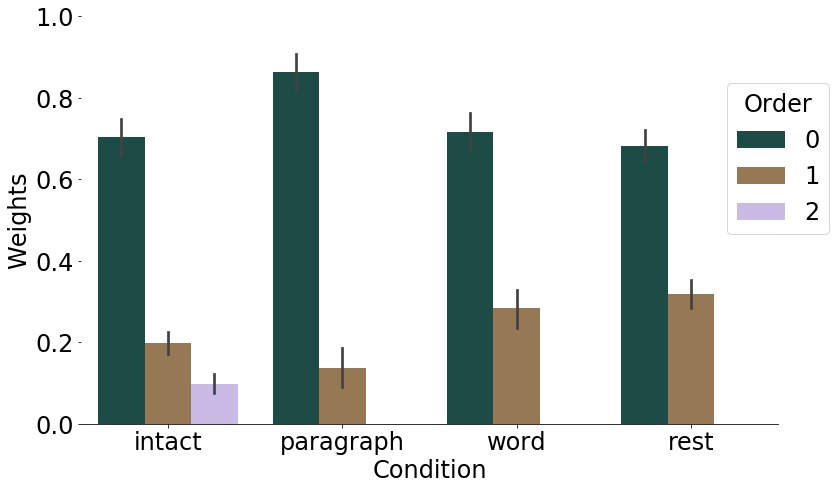

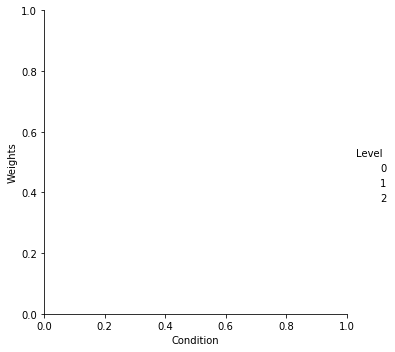

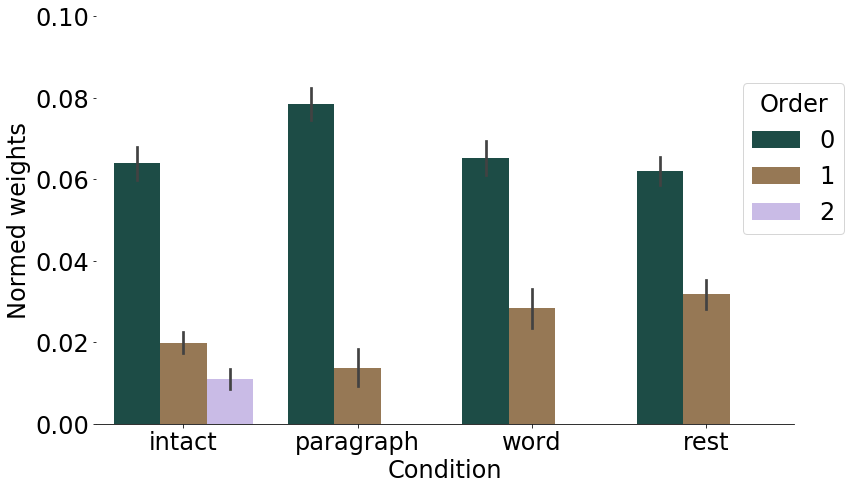

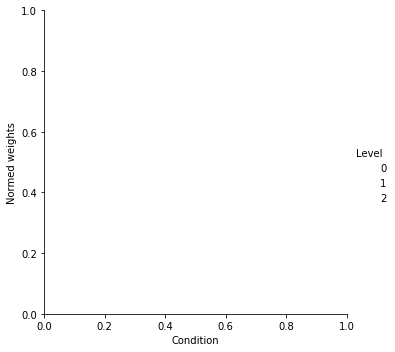

0.8898077577740131
0.04129049577073888
0.01711377090365687
0.026614260213566648
0.025173715338025187
1.0
1.0
0.6811005445700402
0.31889945542995984
0.8898077577740131
0.04129049577073888
0.01711377090365687
0.026614260213566648
0.025173715338025187
1.0
1.0
0.6811005445700402
0.31889945542995984
0.8898077577740131
0.04129049577073888
0.01711377090365687
0.026614260213566648
0.025173715338025187
1.0
1.0
0.6811005445700402
0.31889945542995984
0.8898077577740131
0.04129049577073888
0.01711377090365687
0.026614260213566648
0.025173715338025187
1.0
1.0
0.6811005445700402
0.31889945542995984
0.8898077577740131
0.04129049577073888
0.01711377090365687
0.026614260213566648
0.025173715338025187
1.0
1.0
0.6811005445700402
0.31889945542995984
0.8898077577740131
0.04129049577073888
0.01711377090365687
0.026614260213566648
0.025173715338025187
1.0
1.0
0.6811005445700402
0.31889945542995984
0.8898077577740131
0.04129049577073888
0.01711377090365687
0.026614260213566648
0.025173715338025187
1.0
1.0
0.6

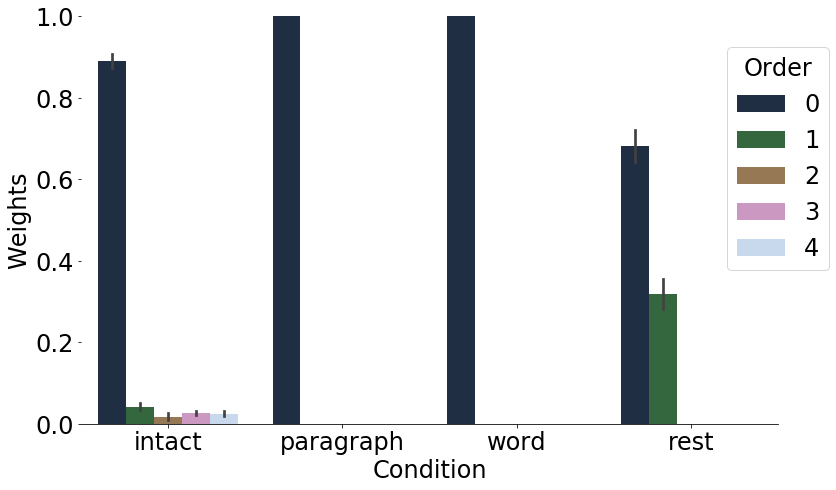

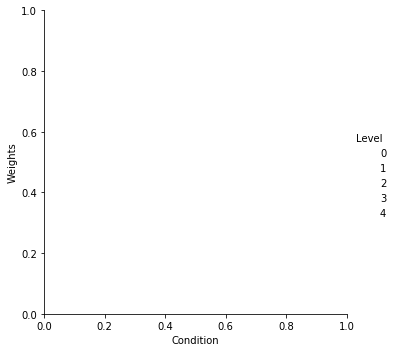

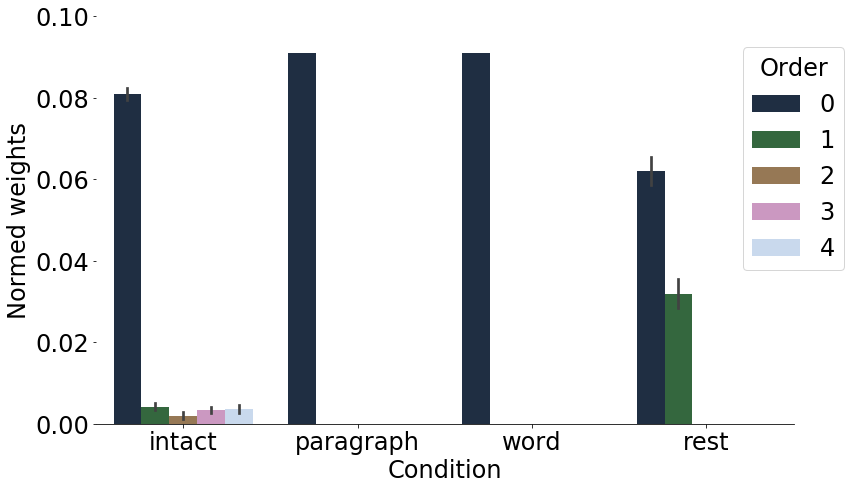

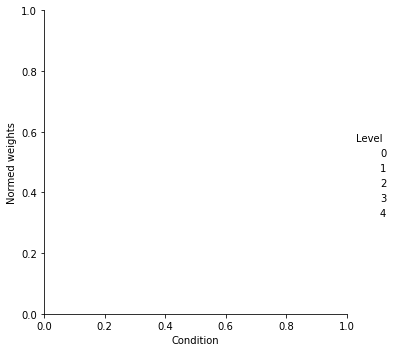

In [148]:

factors = 700
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

split_by = 'Reduction'

for i in eval(split_by + '_type'):
    new_melt = pd.DataFrame()

    all_data = average_param(pieman_params, pieman_conds)
    max_levels = max_level_bycolumn(all_data[all_data[split_by]==i], y='Relative accuracy')
    for p in pieman_params:
        
        param_name = os.path.basename(os.path.splitext(p)[0])
        p_split = param_name.split('_')
        
        if p_split[1] == i:
            
            for e, cond in enumerate(pieman_conds):

                p_df = full_data[full_data['Condition']==cond]

                max_level = max_levels[e]
                #max_level = 10

                p_df = p_df[p_df['Level'] == max_level]

                for c in np.arange(max_level + 1):
                    
                    melted_temp_df = pd.DataFrame()

                    melted_temp_df['Weights'] = p_df['level_' + str(c)]
                    melted_temp_df['Normed weights'] = p_df['level_' + str(c)]/(11-c)

                    melted_temp_df['Level'] = c

                    melted_temp_df['Condition'] = p_df['Condition']

                    if new_melt.empty:
                        new_melt = melted_temp_df
                    else:
                        new_melt= new_melt.append(melted_temp_df)


    new_melt= new_melt.append(melted_temp_df)

    p_split = param_name.split('_')

    title = p_split[0] + ' ' + p_split[1] + ' ' + p_split[-2] + ' ' + p_split[-1] 
    #outfile=None
    outfile = os.path.join(figdir, i + '_weights_ave_'+ analysis_name + '.pdf')
    grouped_barplot(new_melt, 'Condition', 'Weights', 'Level', ymin=0, ymax=1, title = '', outfile=outfile)
    outfile = os.path.join(figdir, i + '_norm_weights_ave_'+ analysis_name + '.pdf')
    grouped_barplot(new_melt, 'Condition', 'Normed weights', 'Level', ymin=0, ymax=.1, title = '', outfile=outfile)
    plt.show()
    plt.close()

In [147]:
new_melt

Weights  Normed weights  Level Condition
4    8.283446e-01    7.530405e-02      0    intact
15   8.794791e-01    7.995265e-02      0    intact
26   9.731345e-01    8.846678e-02      0    intact
37   7.869149e-01    7.153772e-02      0    intact
48   8.709734e-01    7.917940e-02      0    intact
59   1.000000e+00    9.090909e-02      0    intact
4    4.617234e-02    4.617234e-03      1    intact
15   7.079219e-02    7.079219e-03      1    intact
26   0.000000e+00    0.000000e+00      1    intact
37   9.769354e-02    9.769354e-03      1    intact
48   3.308490e-02    3.308490e-03      1    intact
59   1.734723e-16    1.734723e-17      1    intact
4    1.586128e-03    1.762364e-04      2    intact
15   4.757900e-03    5.286556e-04      2    intact
26   5.590758e-03    6.211953e-04      2    intact
37   0.000000e+00    0.000000e+00      2    intact
48   9.074784e-02    1.008309e-02      2    intact
59   1.387779e-16    1.541976e-17      2    intact
4    5.186454e-02    6.483068e-03      3    intact
15   1.343509e-02    1.679387e-03      3    intact
26   2.127470e-02    2.659337e-03      3    intact
37   6.791734e-02    8.489667e-03      3    intact
48   5.193893e-03    6.492366e-04      3    intact
59   0.000000e+00    0.000000e+00      3    intact
4    7.203240e-02    1.029034e-02      4    intact
15   3.153570e-02    4.505100e-03      4    intact
26   0.000000e+00    0.000000e+00      4    intact
37   4.747419e-02    6.782027e-03      4    intact
48   2.775346e-17    3.964780e-18      4    intact
59   0.000000e+00    0.000000e+00      4    intact
..            ...             ...    ...       ...
1    5.000030e-01    4.545481e-02      0      rest
12   7.399583e-01    6.726893e-02      0      rest
23   9.548641e-01    8.680583e-02      0      rest
34   5.931273e-01    5.392066e-02      0      rest
45   5.000031e-01    4.545483e-02      0      rest
56   1.000000e+00    9.090909e-02      0      rest
67   4.829307e-01    4.390279e-02      0      rest
78   1.000000e+00    9.090909e-02      0      rest
89   5.000251e-01    4.545683e-02      0      rest
100  5.400939e-01    4.909944e-02      0      rest
1    4.999970e-01    4.999970e-02      1      rest
12   2.600417e-01    2.600417e-02      1      rest
23   4.513592e-02    4.513592e-03      1      rest
34   4.068727e-01    4.068727e-02      1      rest
45   4.999969e-01    4.999969e-02      1      rest
56   1.110223e-16    1.110223e-17      1      rest
67   5.170693e-01    5.170693e-02      1      rest
78   0.000000e+00    0.000000e+00      1      rest
89   4.999749e-01    4.999749e-02      1      rest
100  4.599061e-01    4.599061e-02      1      rest
1    4.999970e-01    4.999970e-02      1      rest
12   2.600417e-01    2.600417e-02      1      rest
23   4.513592e-02    4.513592e-03      1      rest
34   4.068727e-01    4.068727e-02      1      rest
45   4.999969e-01    4.999969e-02      1      rest
56   1.110223e-16    1.110223e-17      1      rest
67   5.170693e-01    5.170693e-02      1      rest
78   0.000000e+00    0.000000e+00      1      rest
89   4.999749e-01    4.999749e-02      1      rest
100  4.599061e-01    4.599061e-02      1      rest

[706 rows x 4 columns]

SyntaxError: invalid syntax (<ipython-input-146-8233409adc8f>, line 1)

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:32: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


0.24549999999999997
0
isfc eigenvector gaussian 10


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


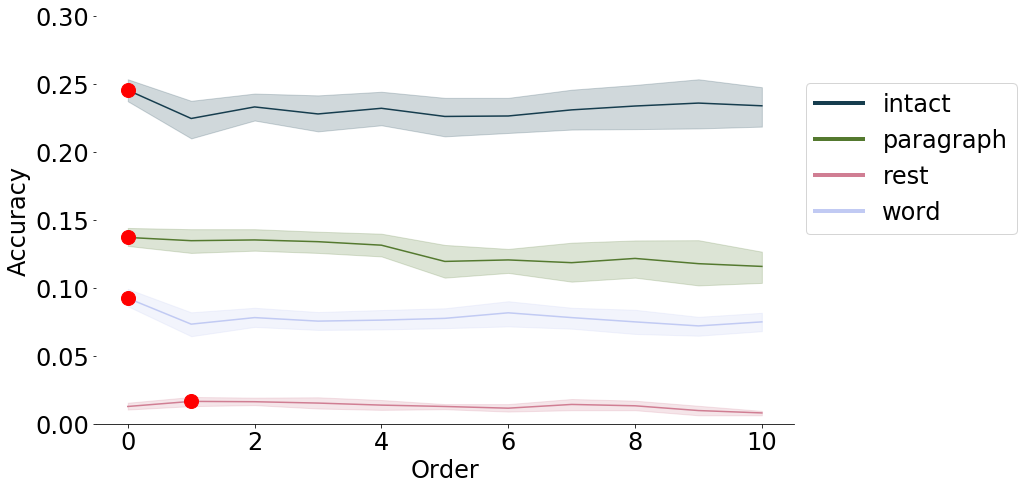

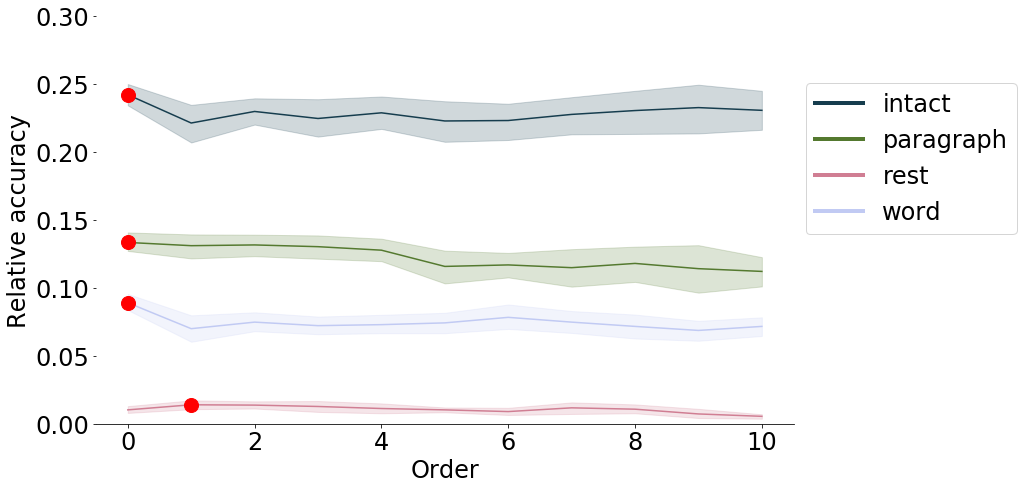

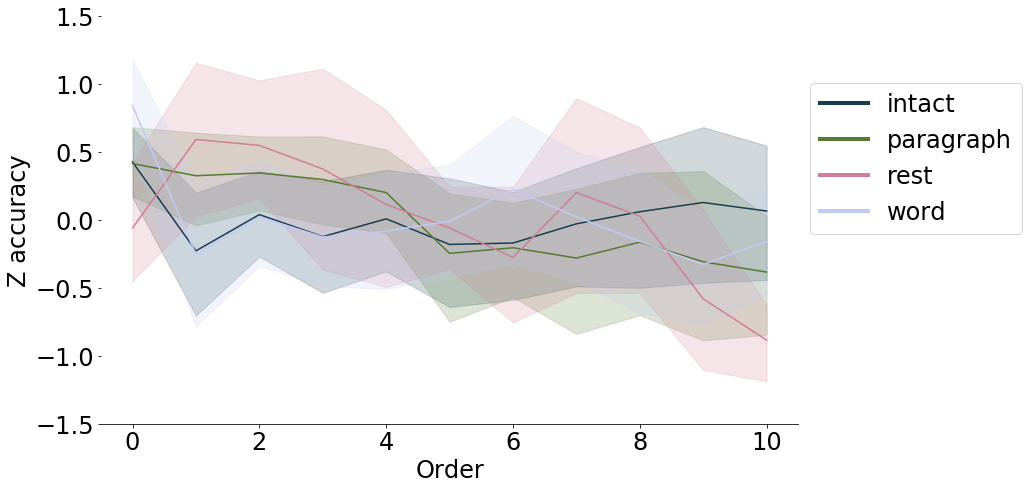

0.23428571428571424
0
isfc eigenvector gaussian 20


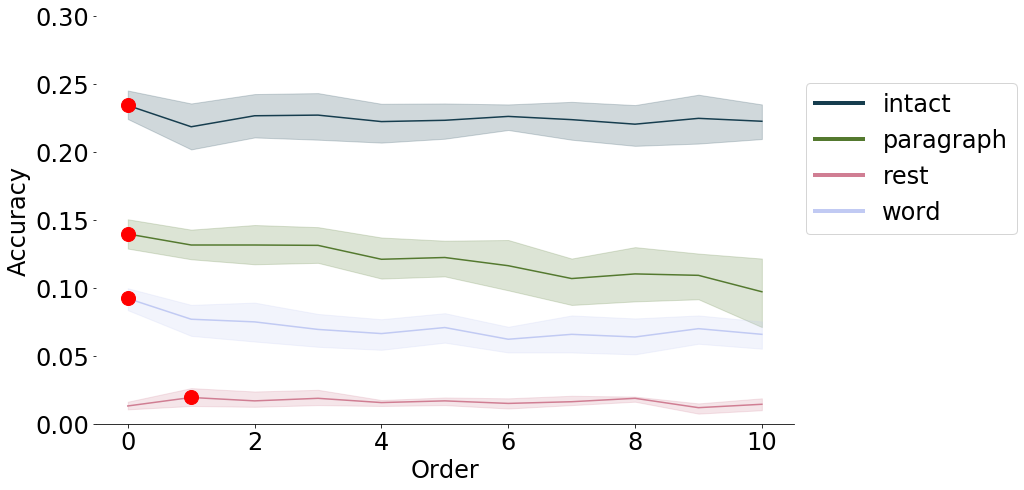

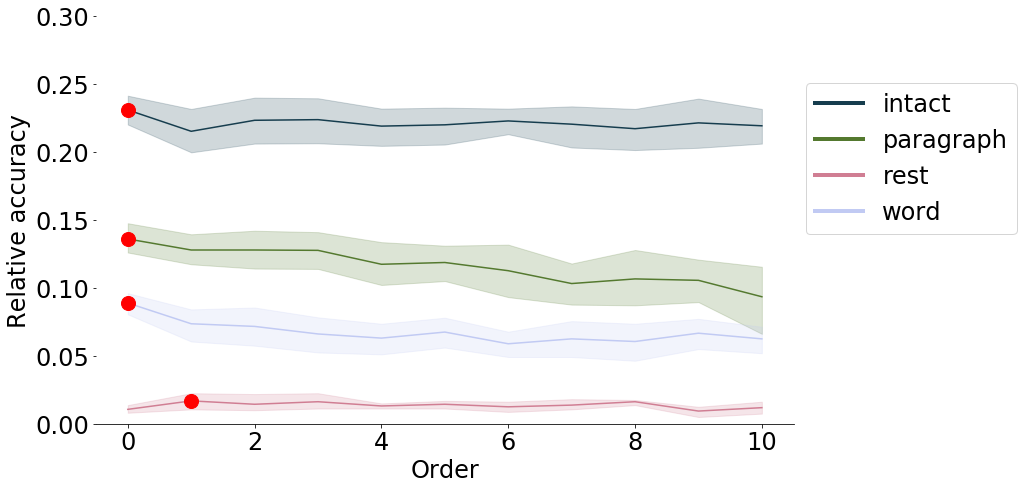

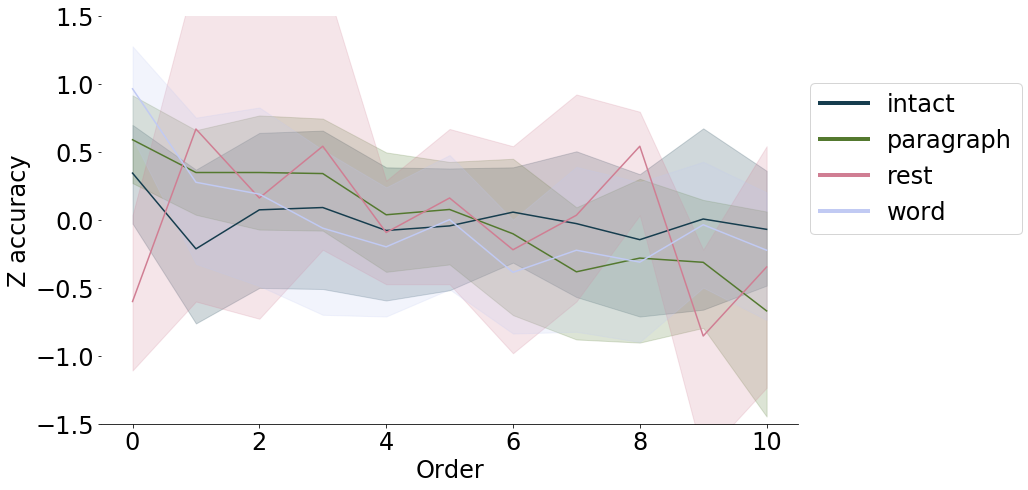

0.23979166666666663
0
isfc eigenvector gaussian 5


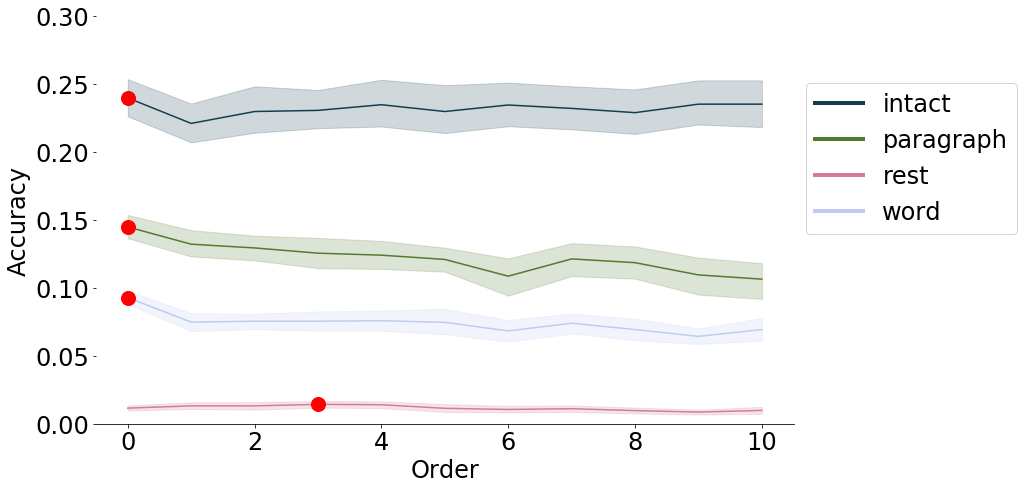

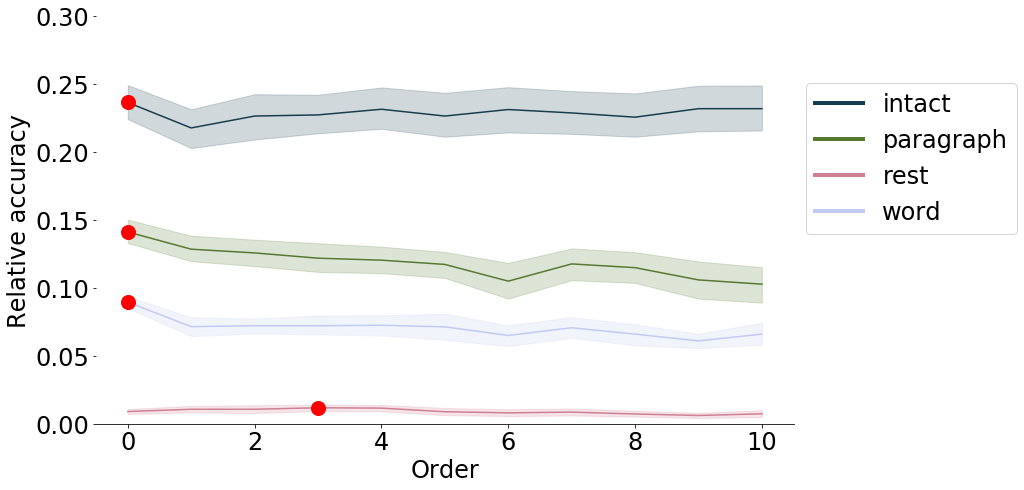

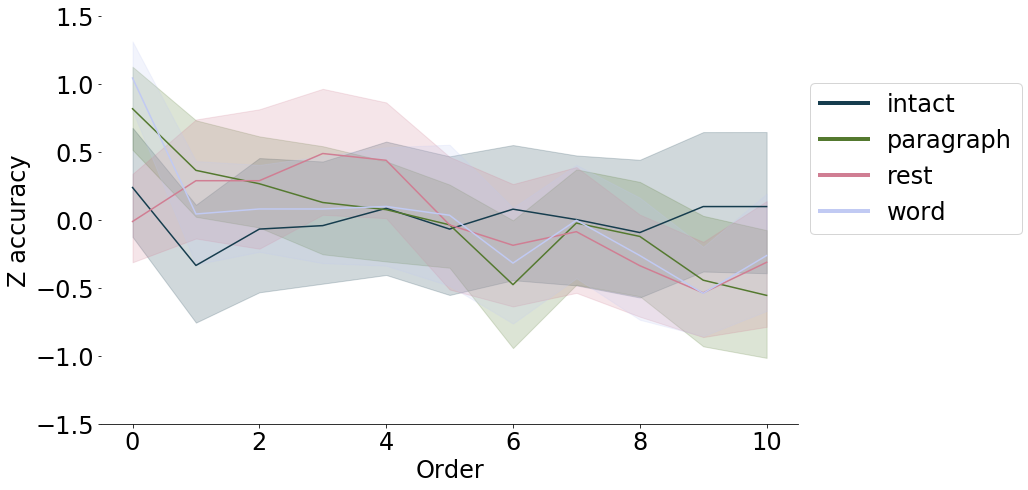

0.22799999999999998
0
isfc eigenvector gaussian 50


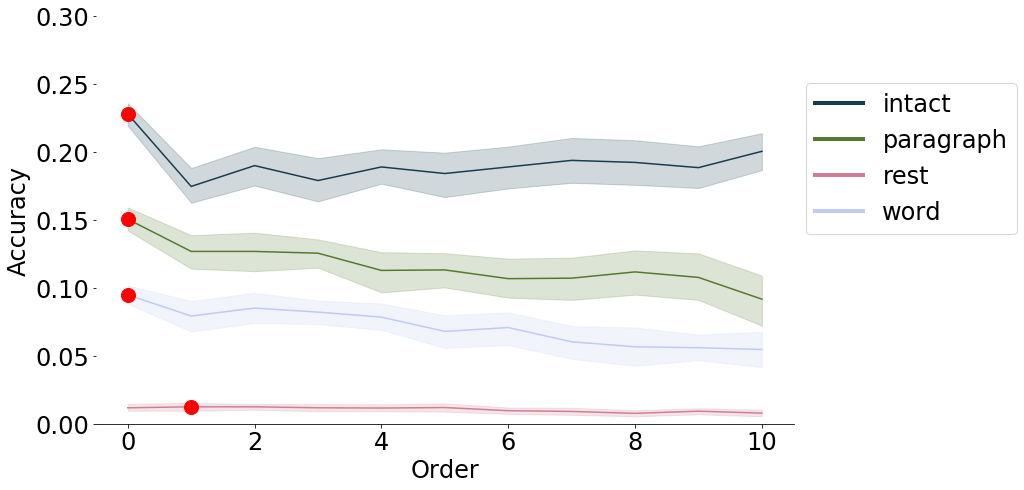

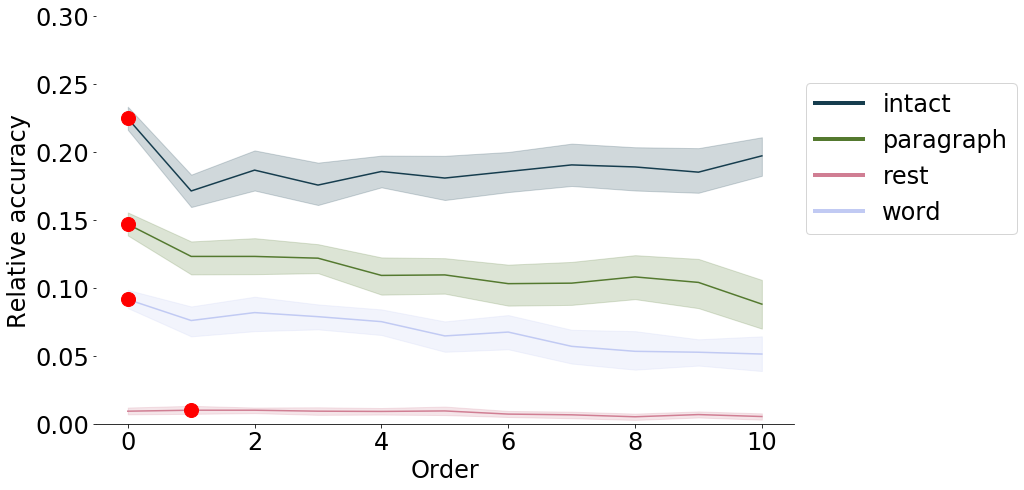

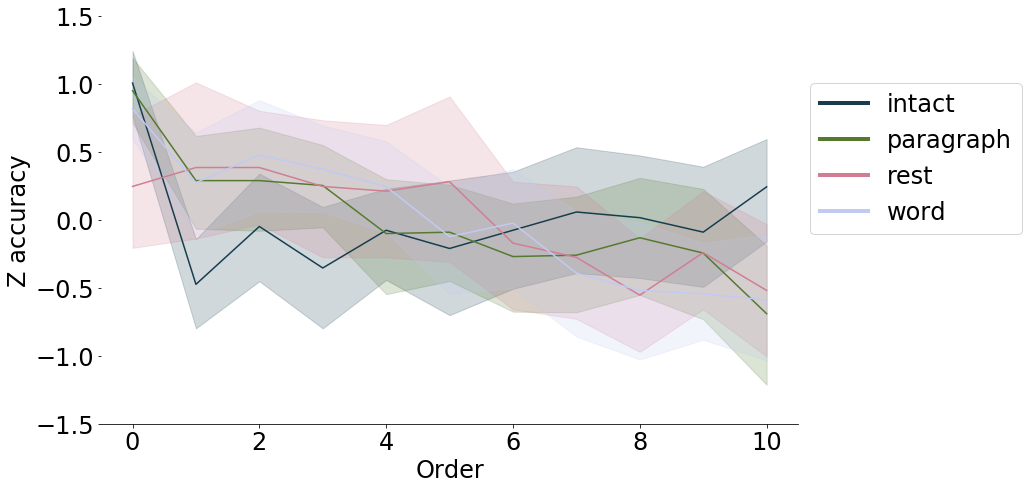

0.24783333333333335
0
isfc eigenvector laplace 10


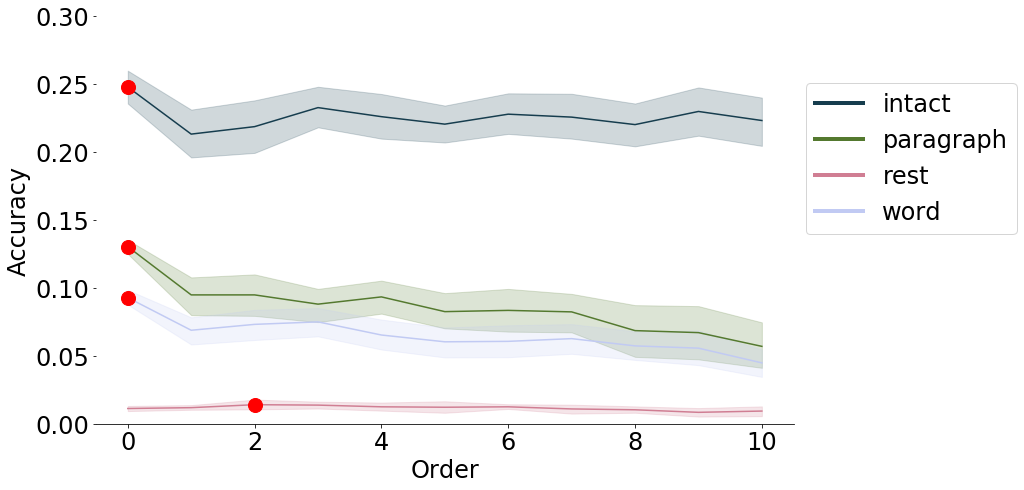

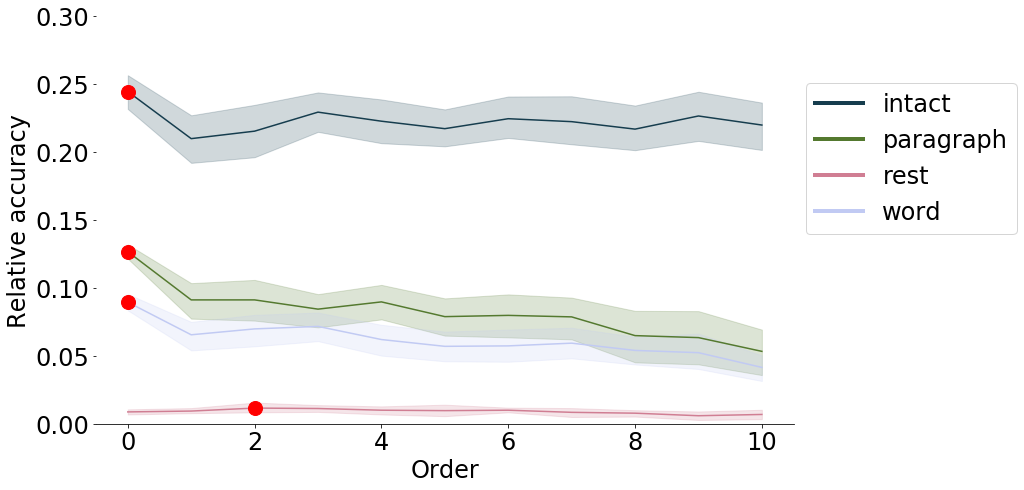

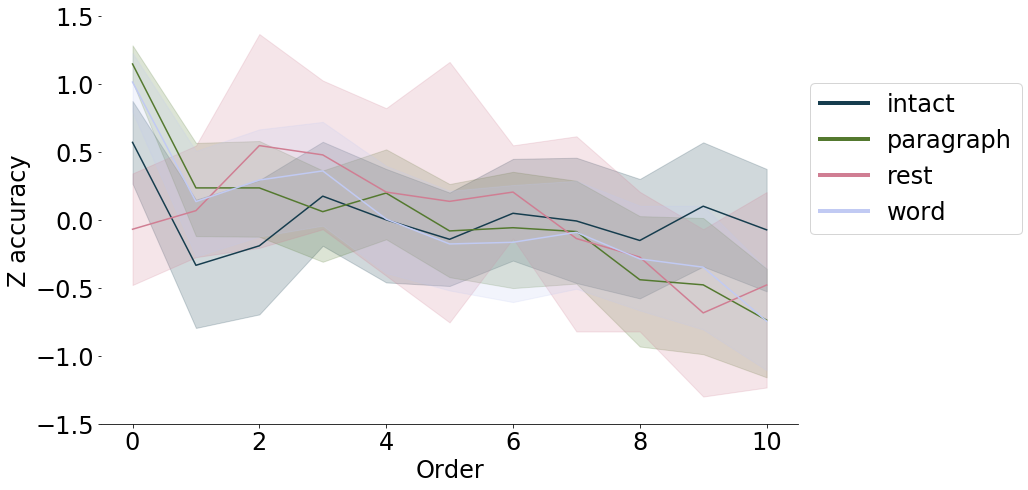

0.23907407407407405
0
isfc eigenvector laplace 20


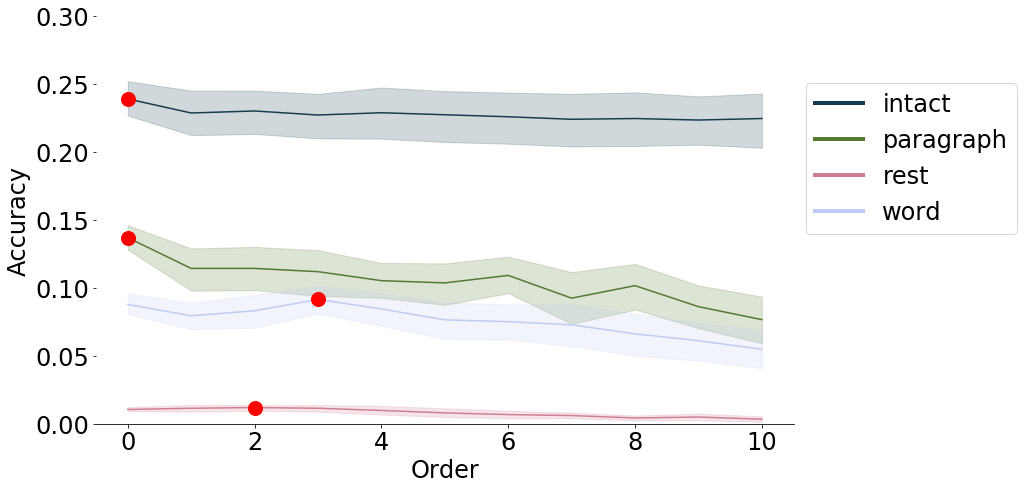

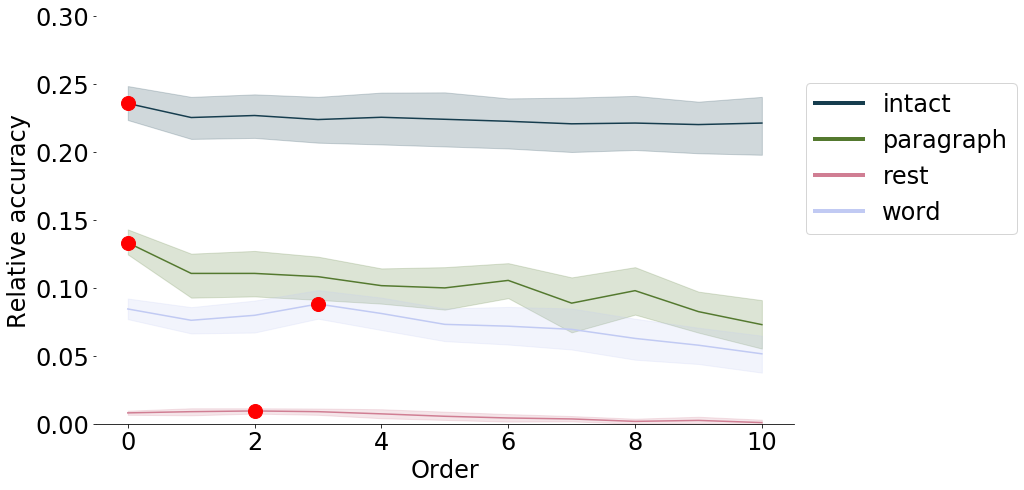

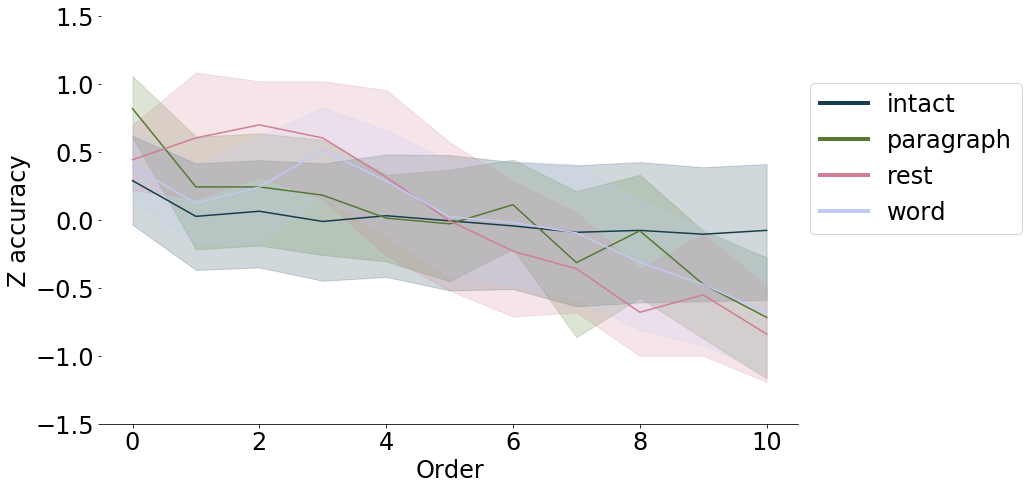

0.242962962962963
0
isfc eigenvector laplace 5


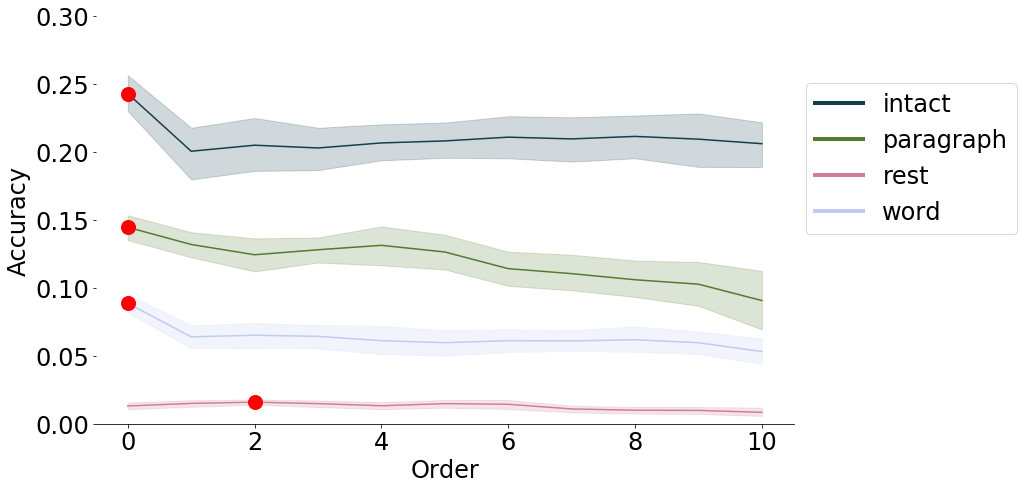

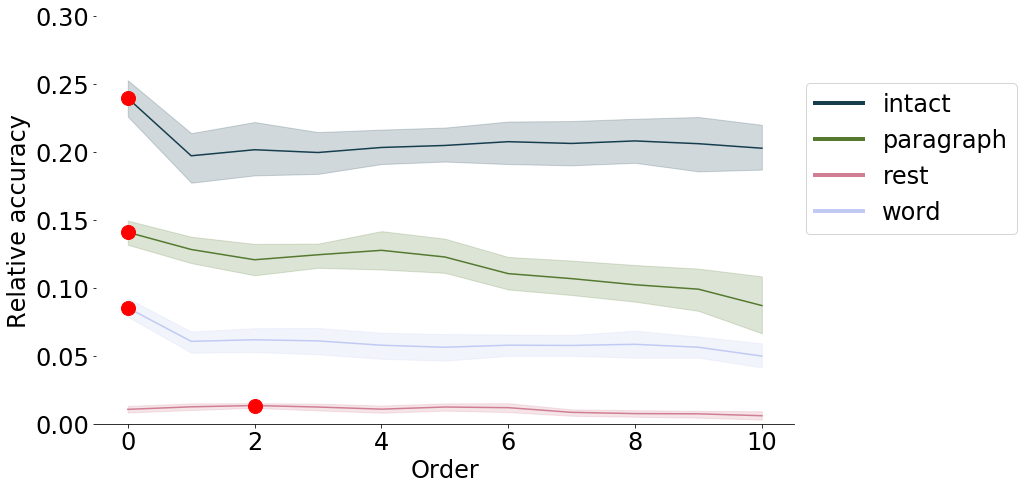

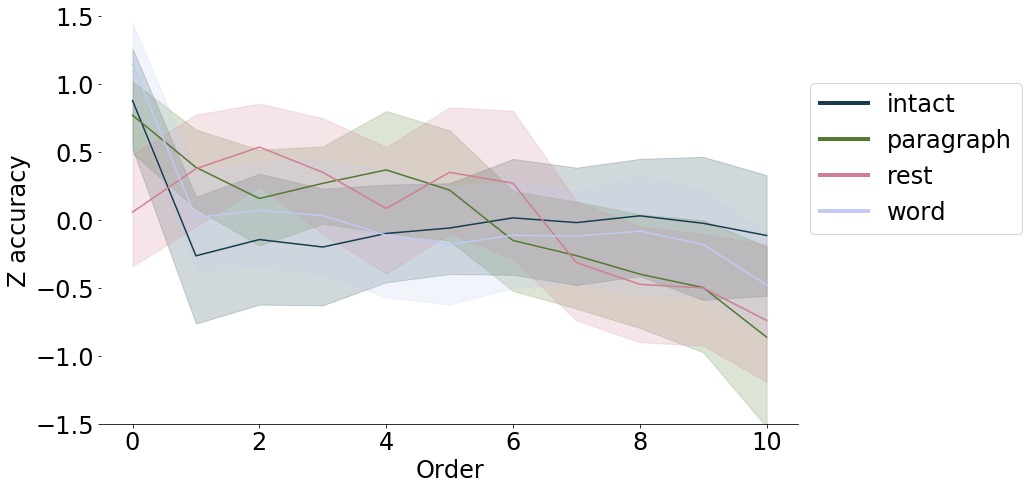

0.25516666666666665
4
isfc eigenvector laplace 50


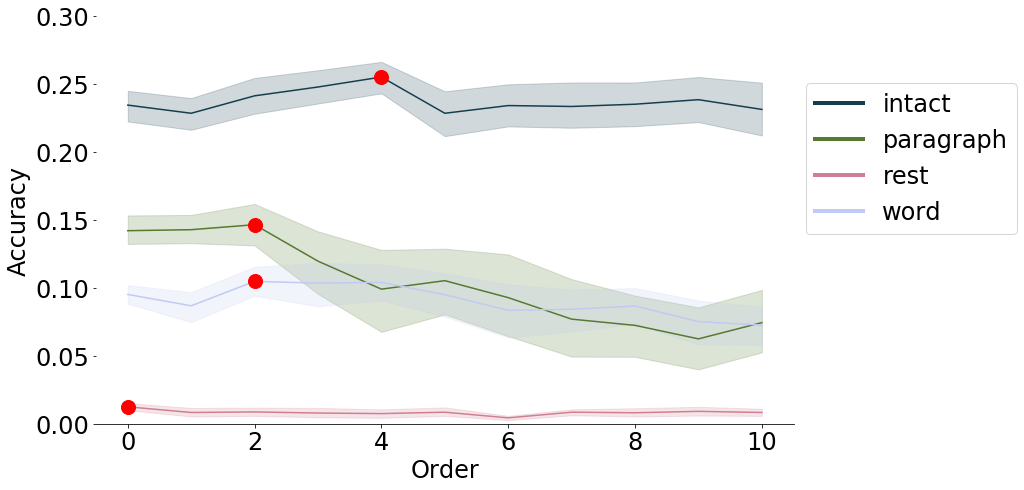

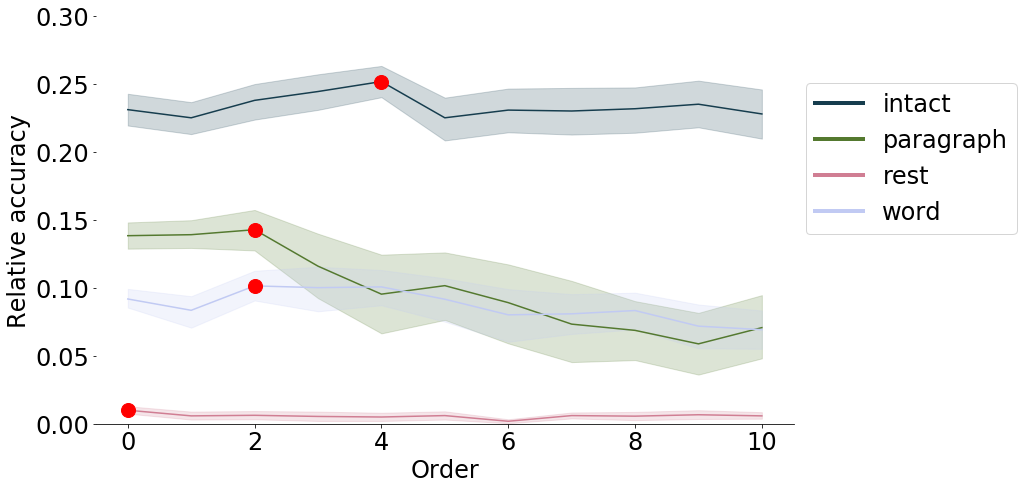

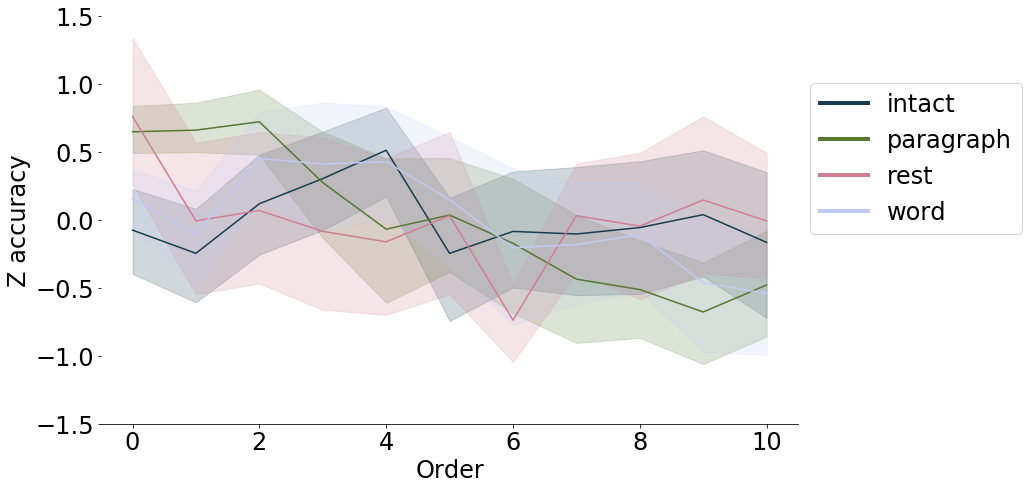

0.2838333333333334
2
isfc eigenvector hat 10


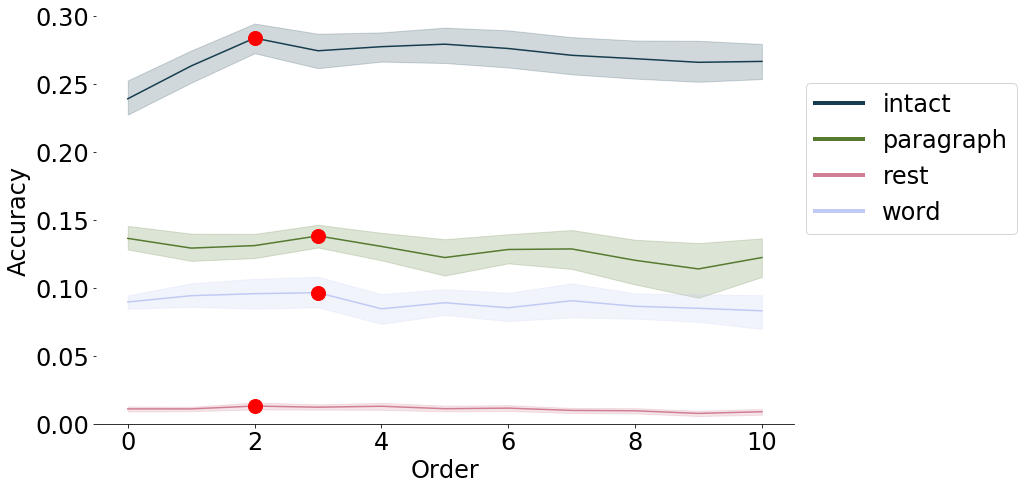

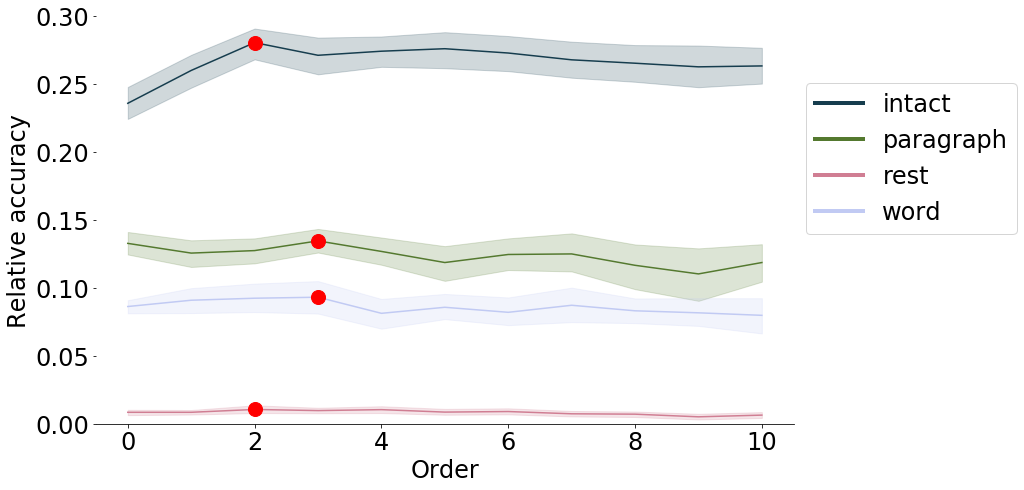

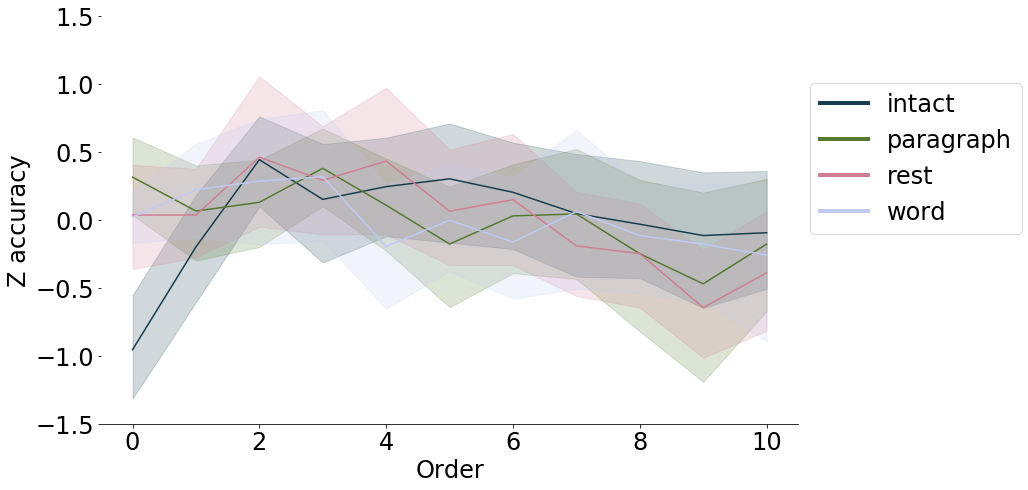

0.26766666666666666
2
isfc eigenvector hat 20


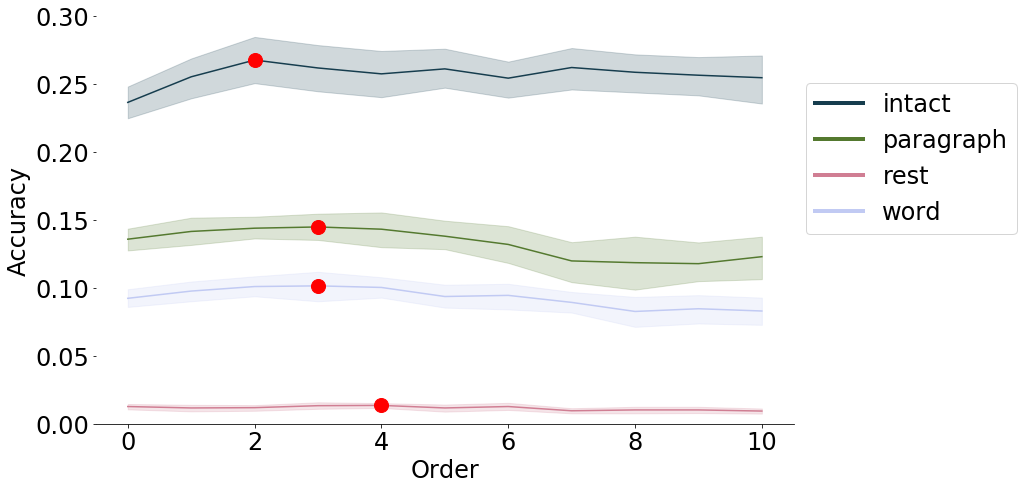

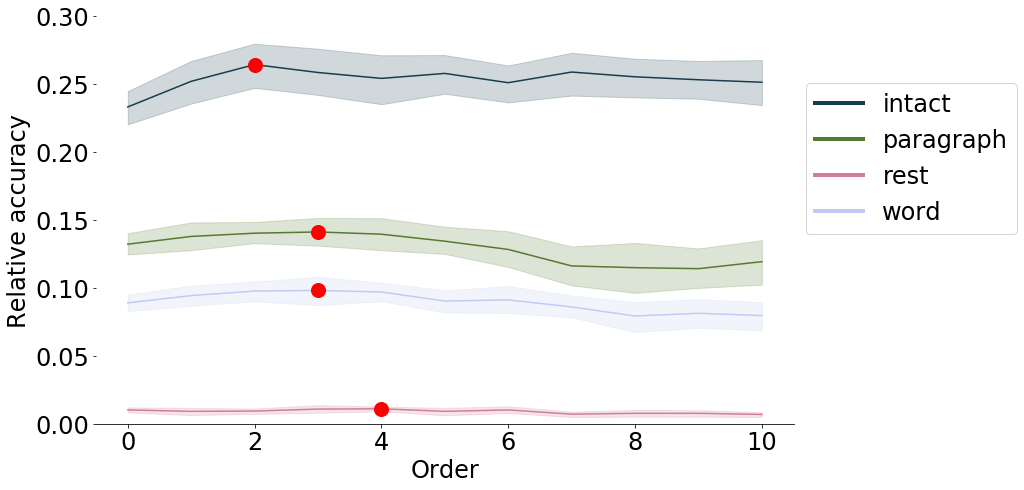

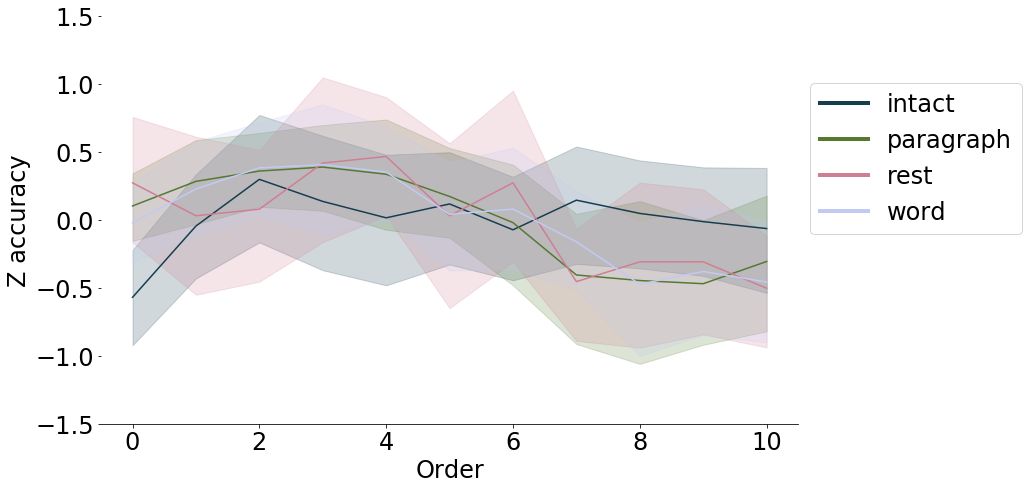

0.27555555555555555
5
isfc eigenvector hat 5


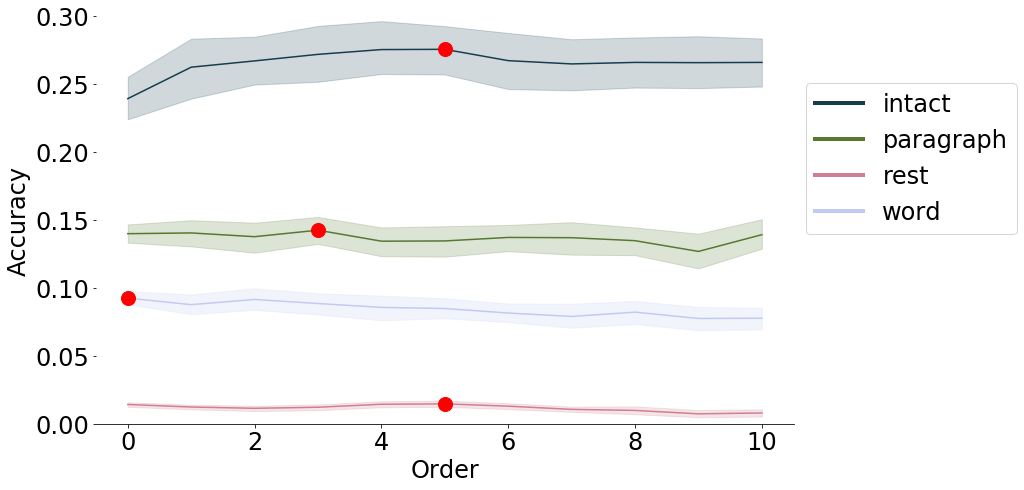

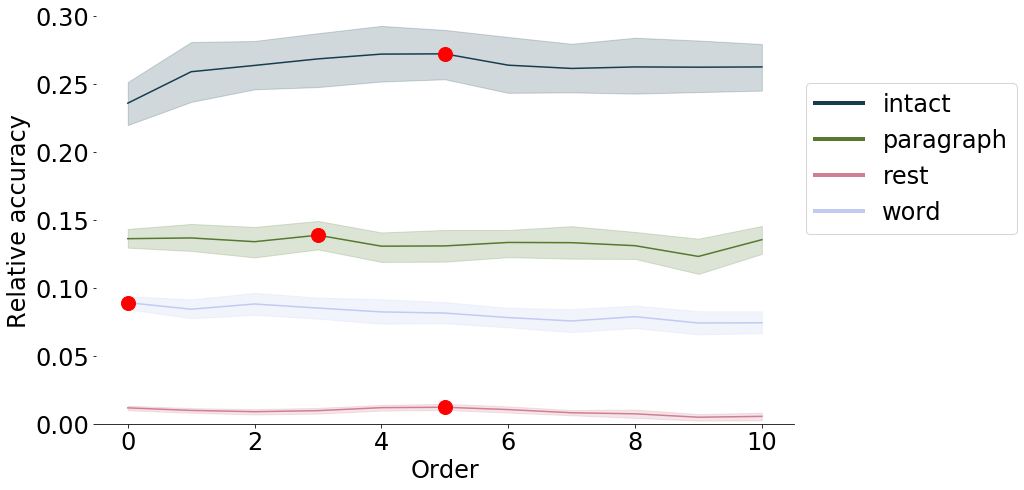

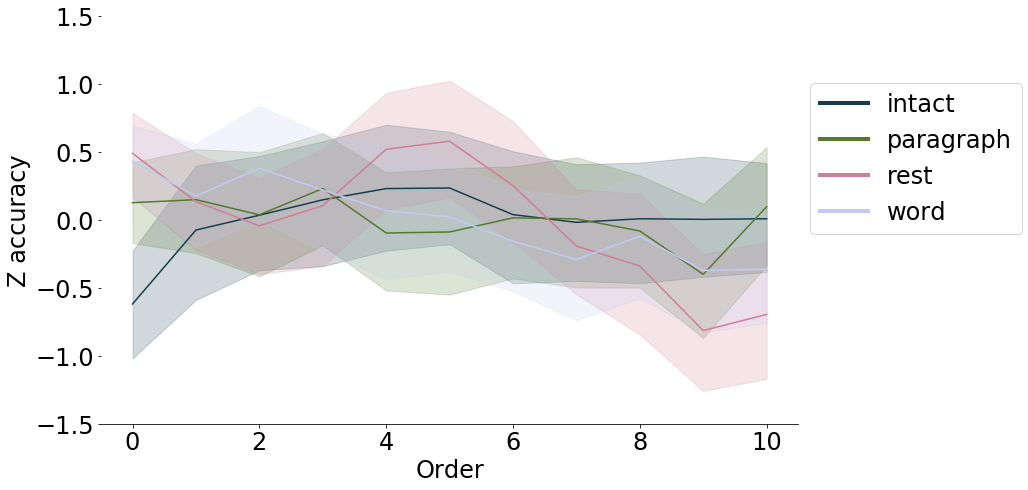

0.26633333333333337
2
isfc eigenvector hat 50


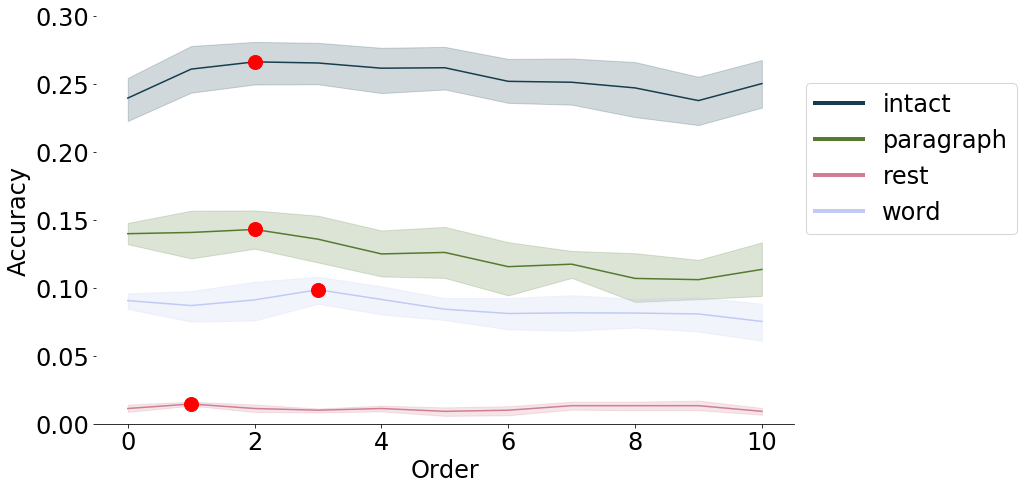

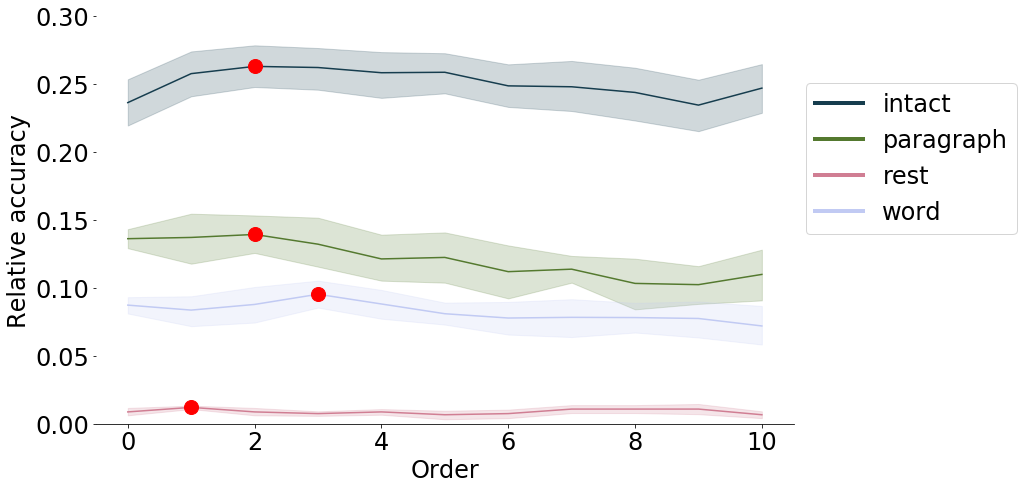

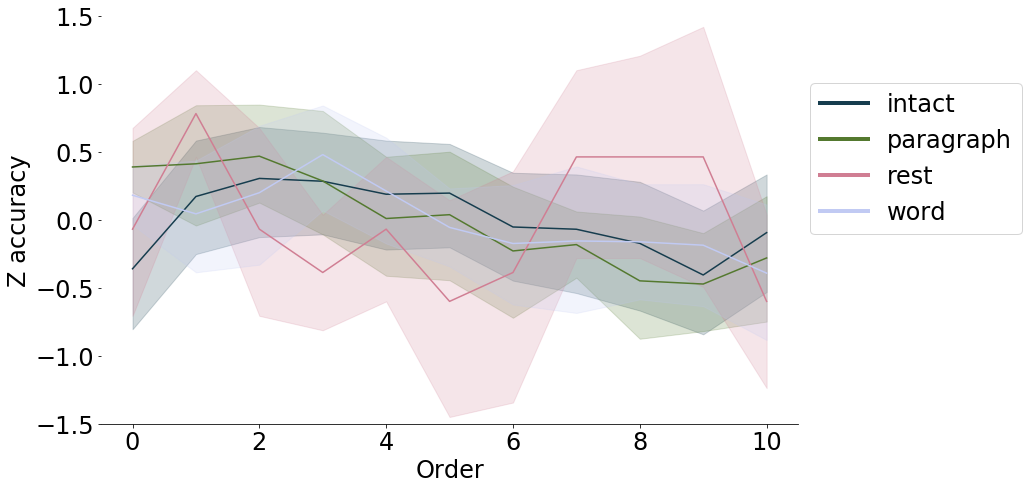

0.252
2
isfc PCA gaussian 10


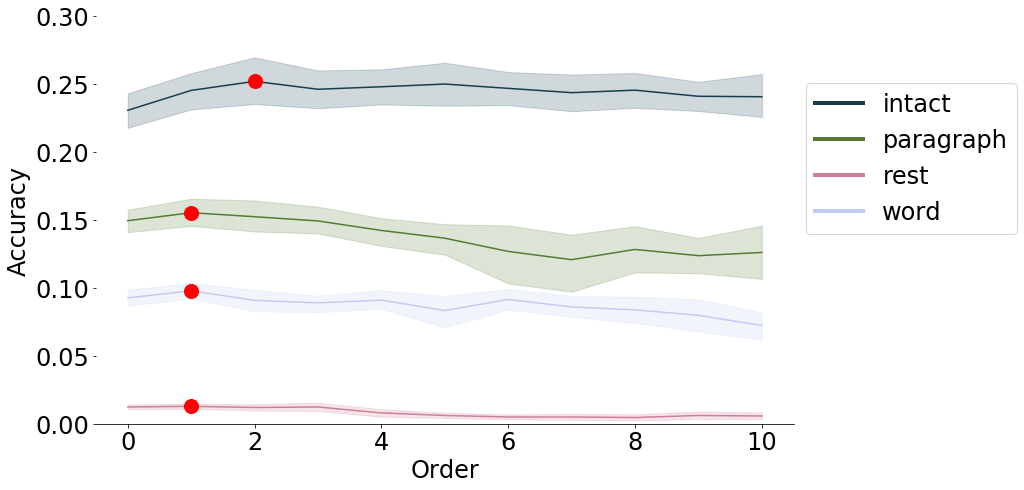

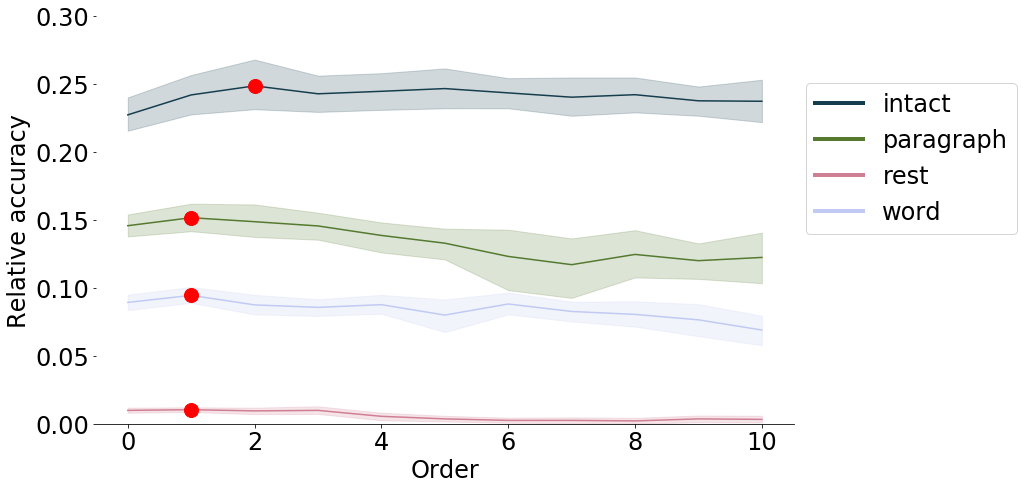

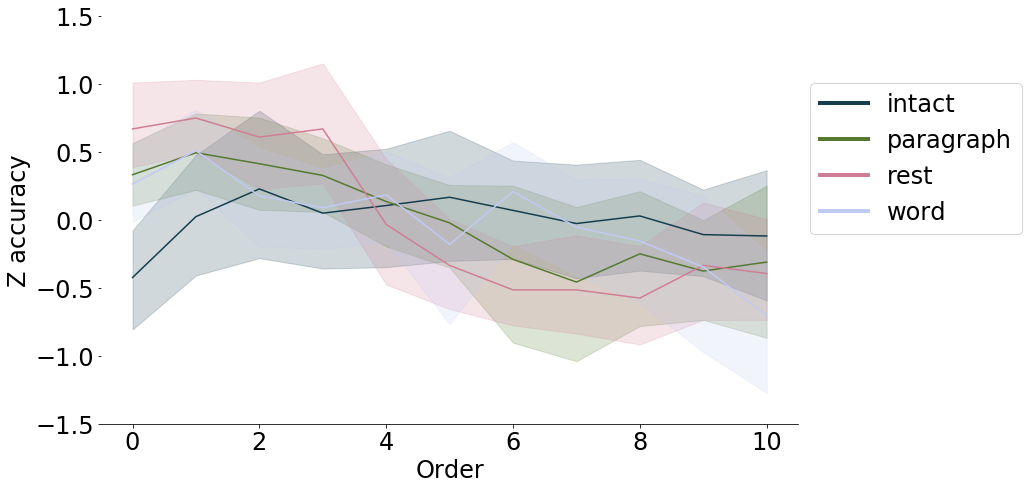

0.27066666666666667
2
isfc PCA gaussian 20


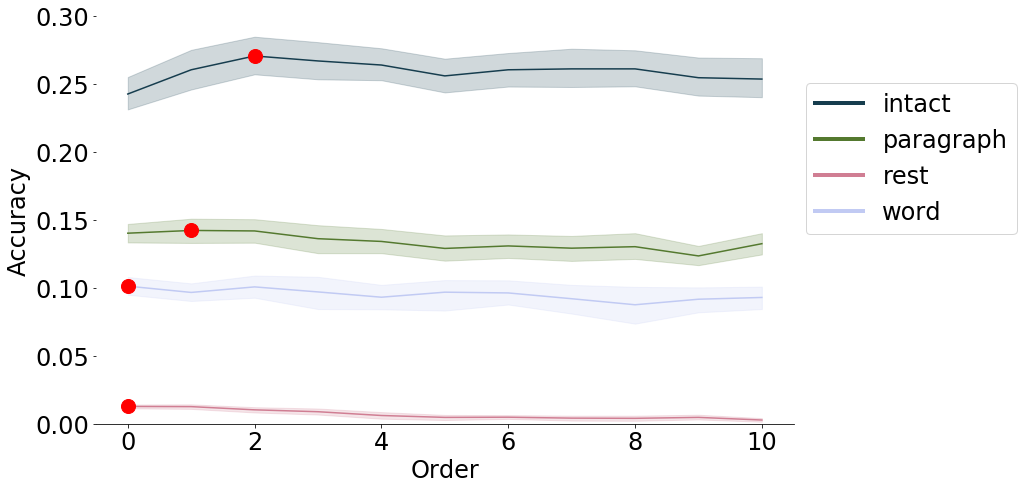

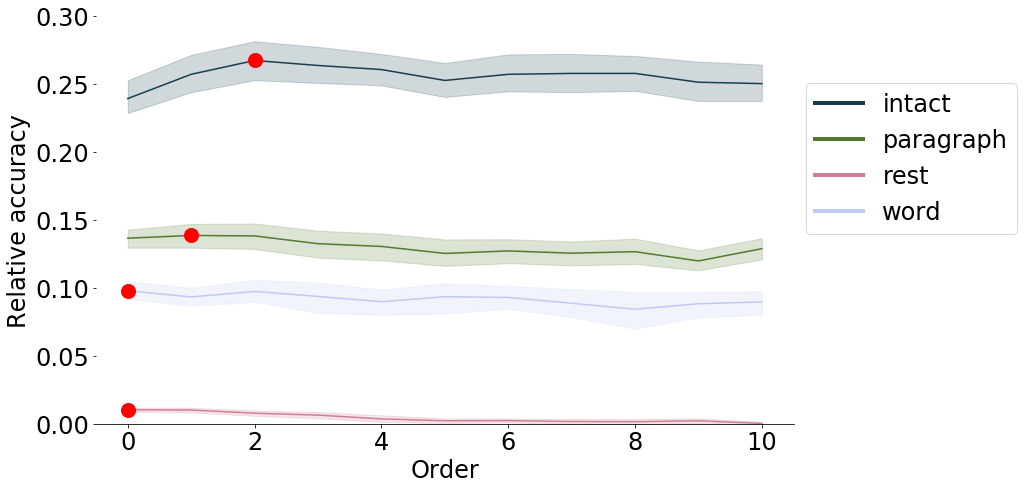

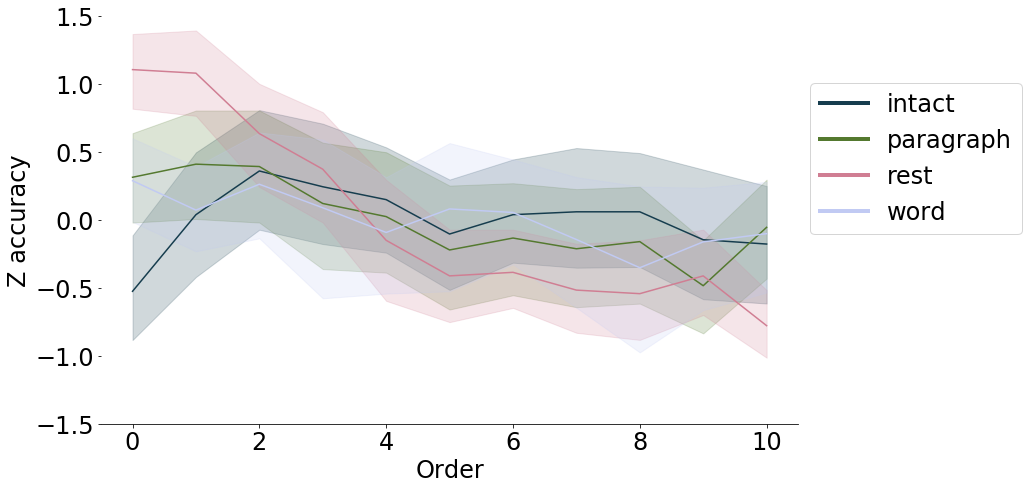

0.261
2
isfc PCA gaussian 5


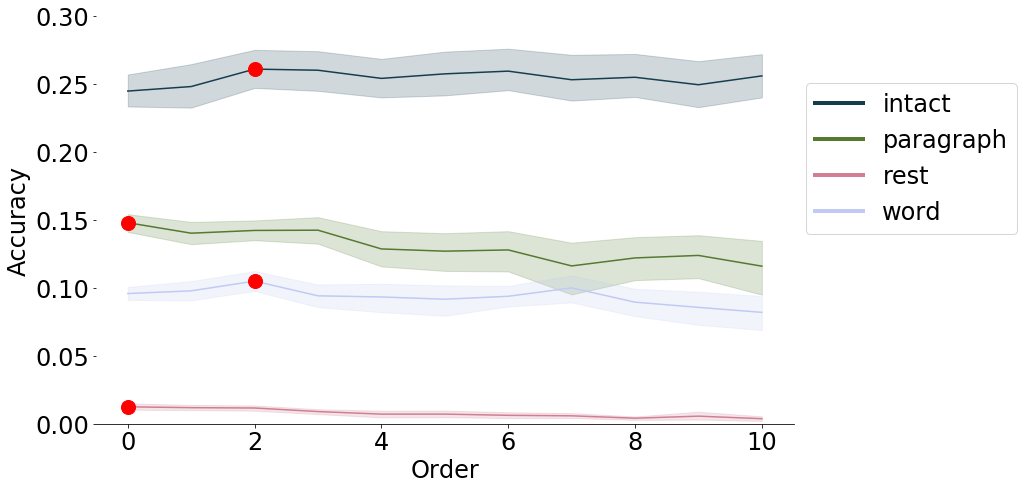

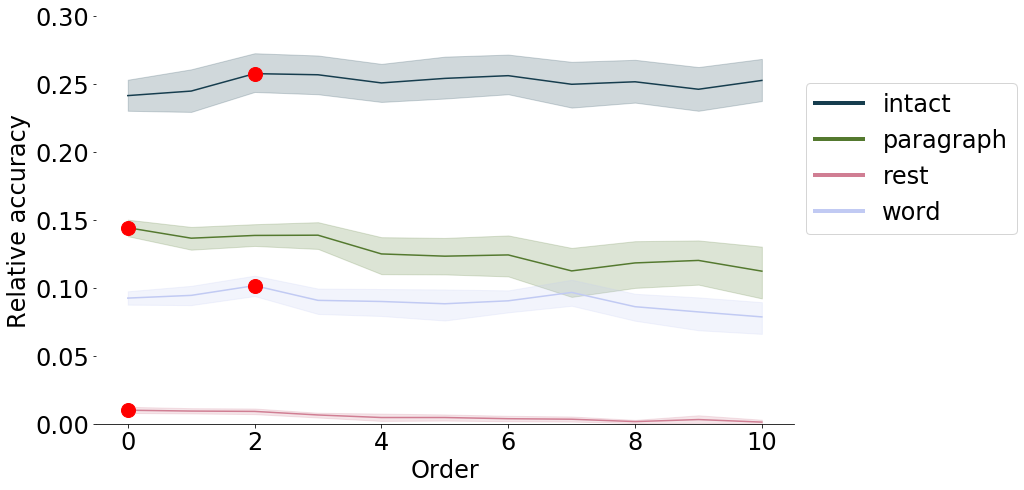

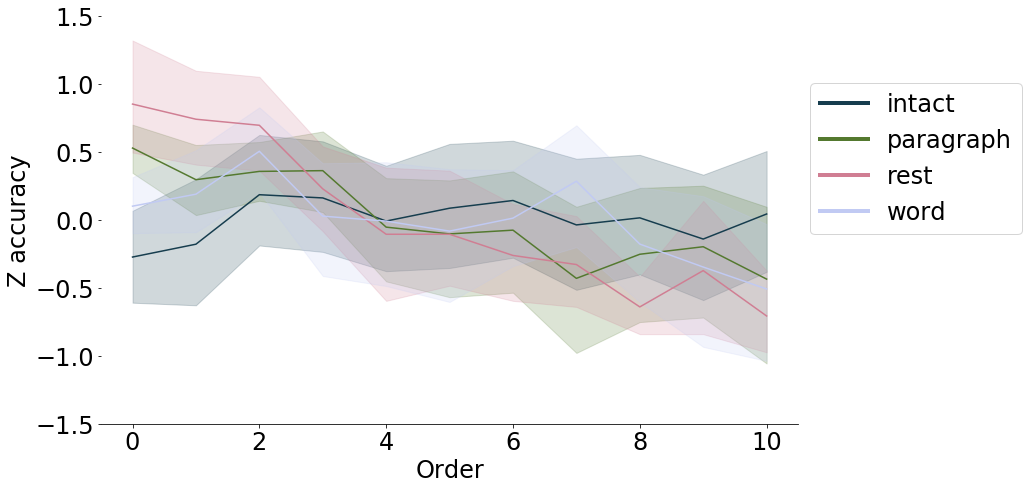

0.25833333333333336
2
isfc PCA gaussian 50


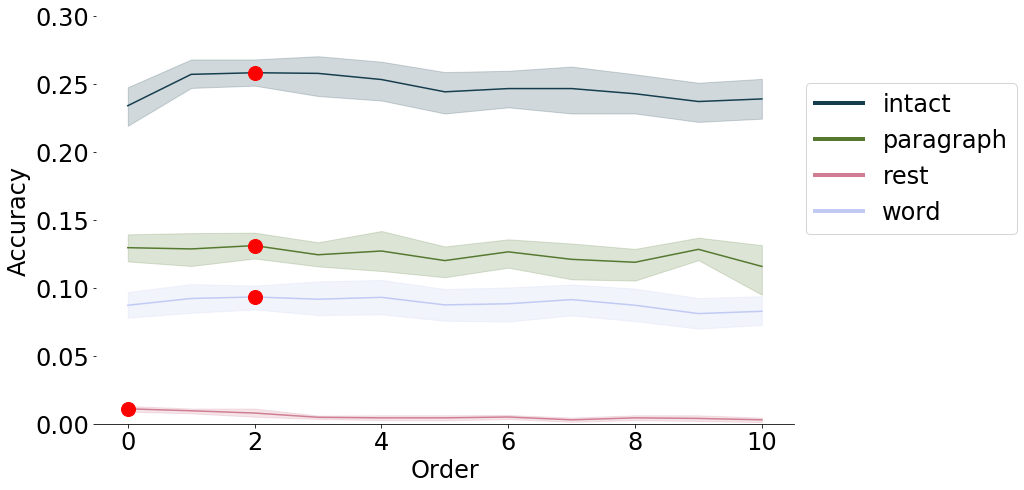

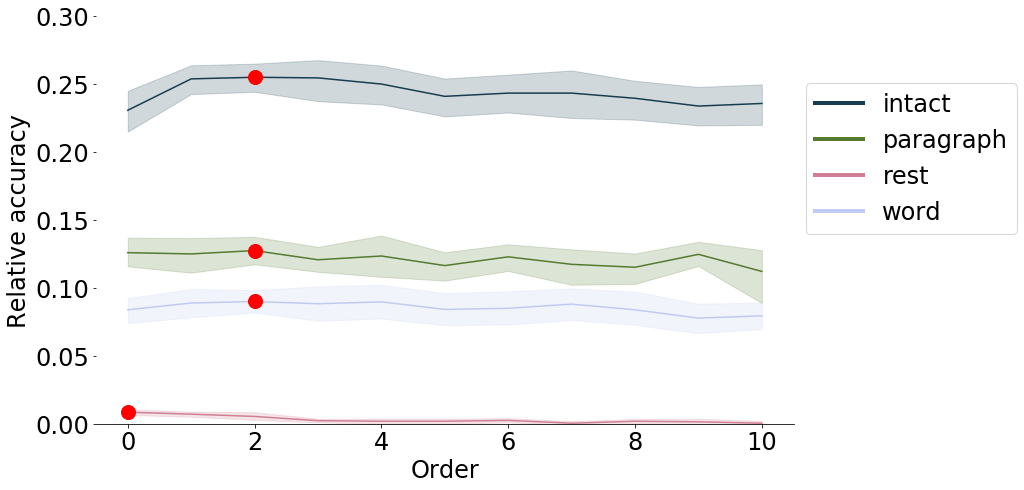

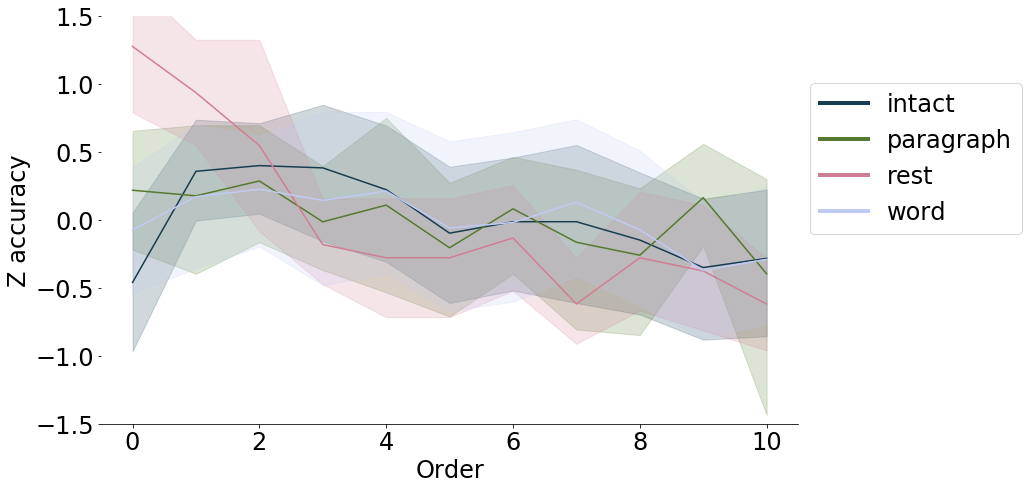

0.25400000000000006
6
isfc PCA laplace 10


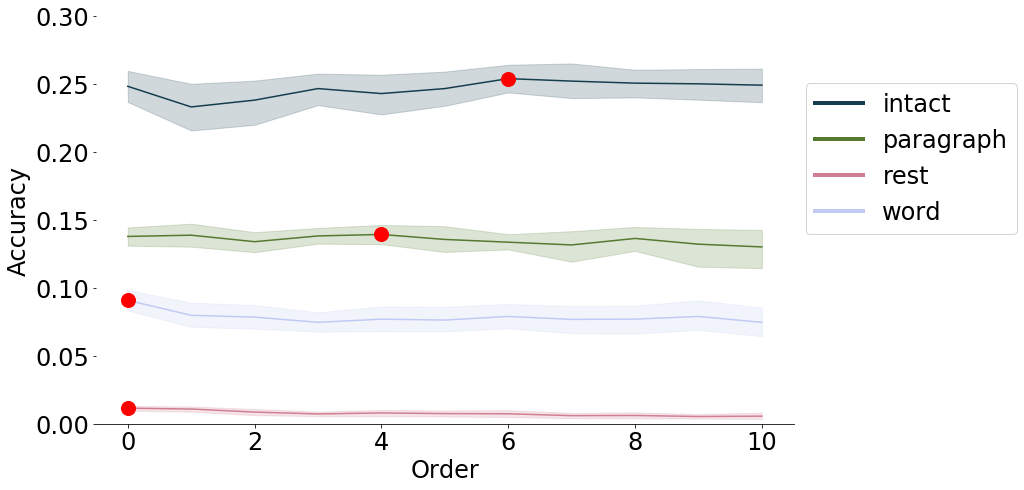

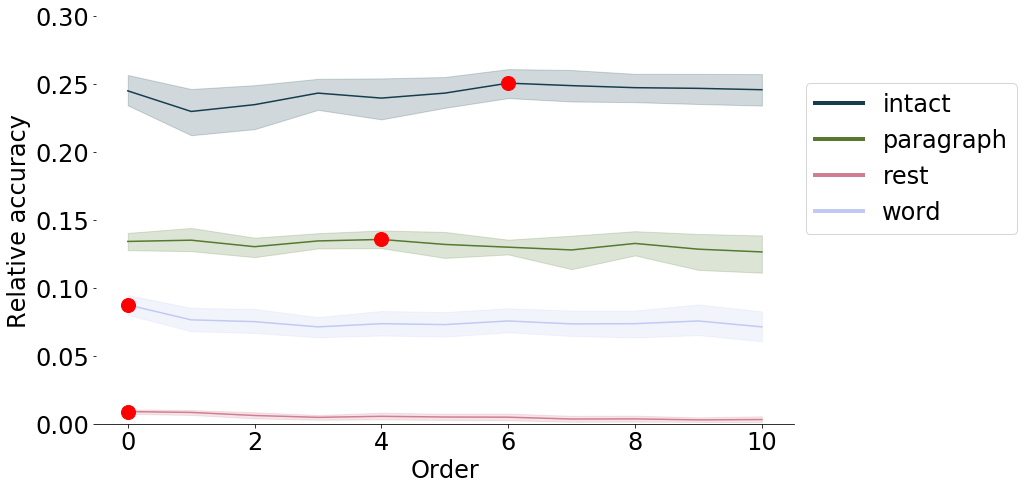

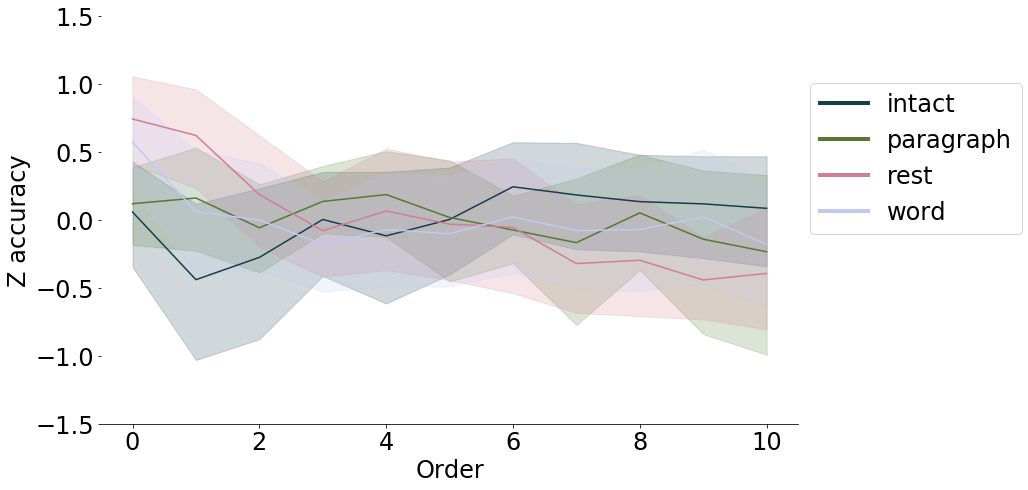

0.24583333333333335
0
isfc PCA laplace 20


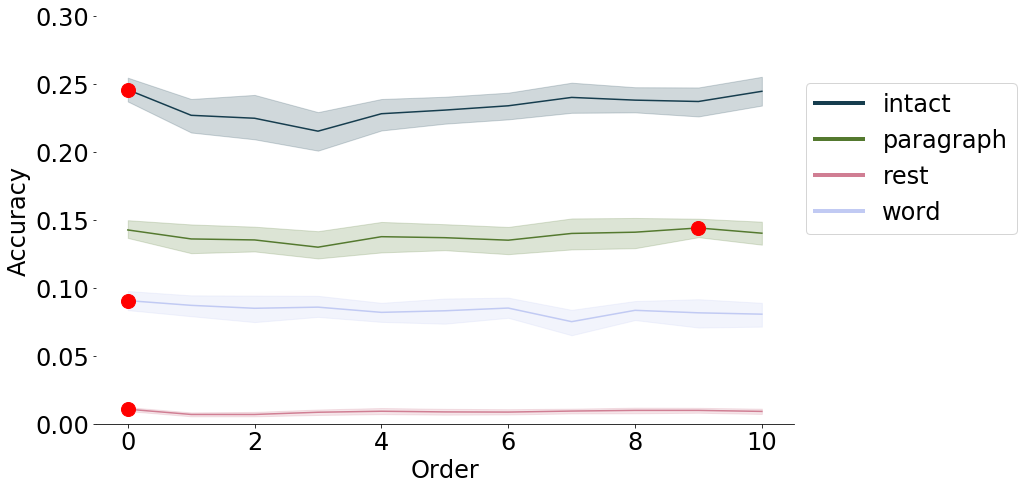

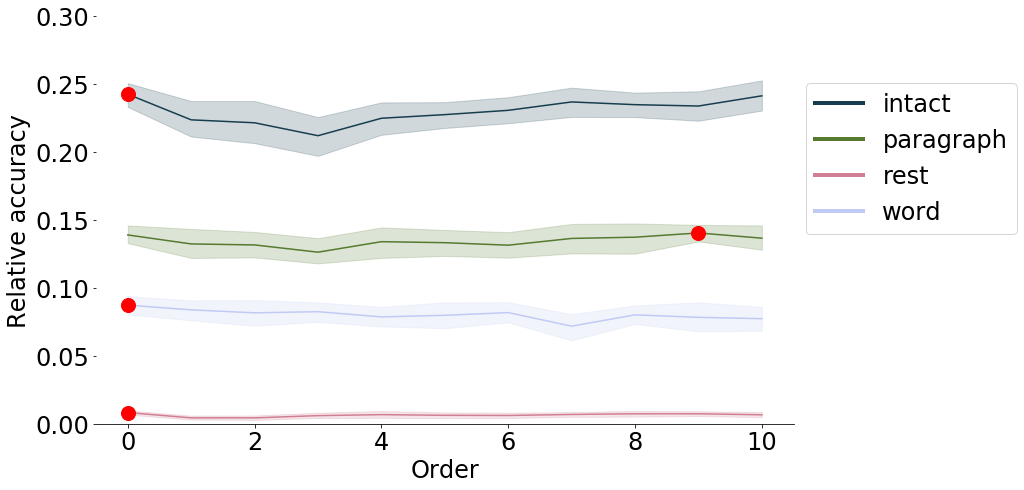

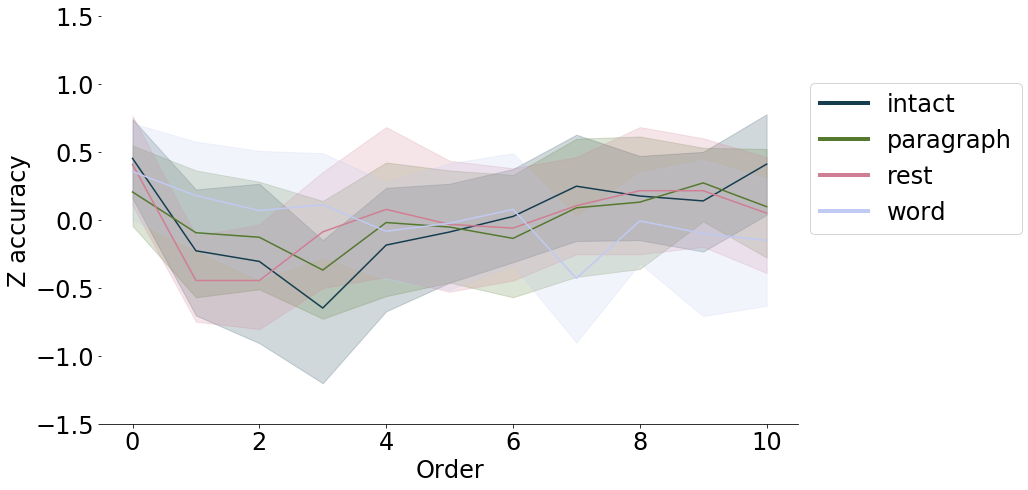

0.25766666666666665
4
isfc PCA laplace 5


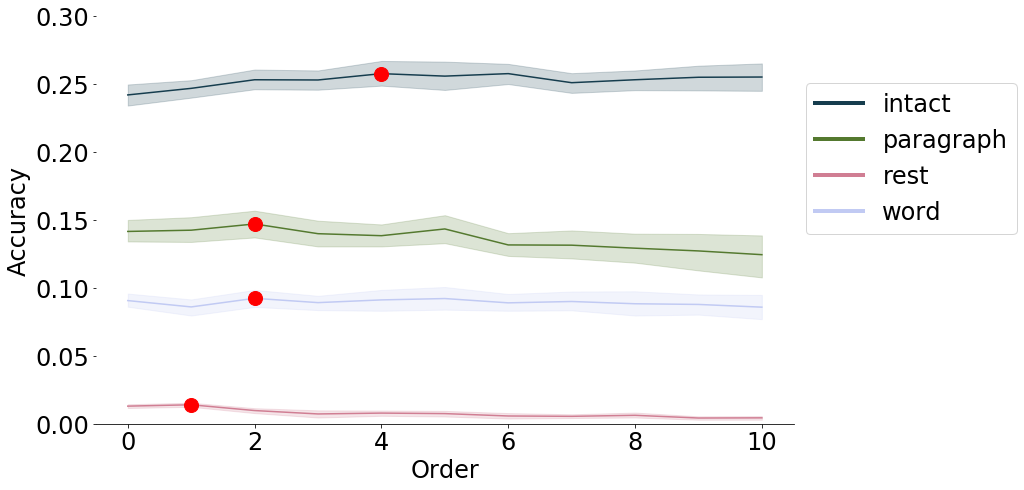

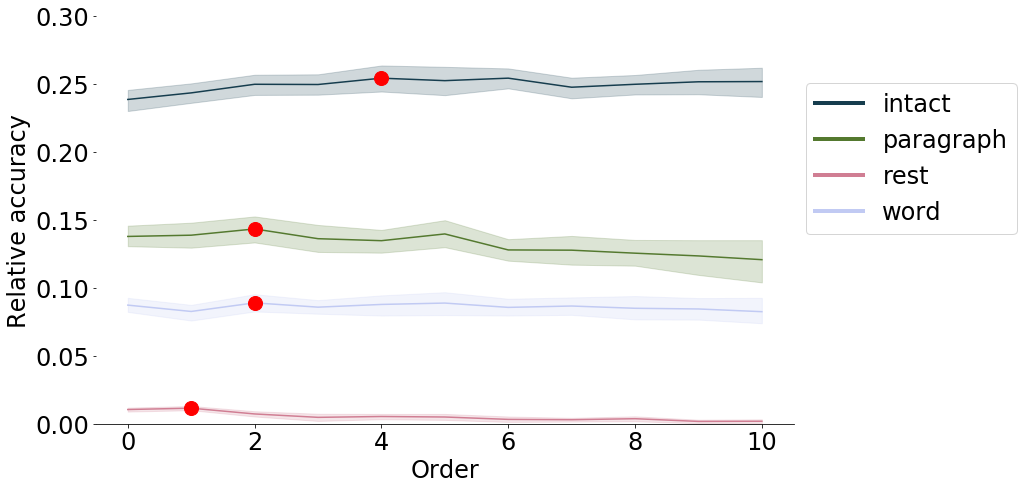

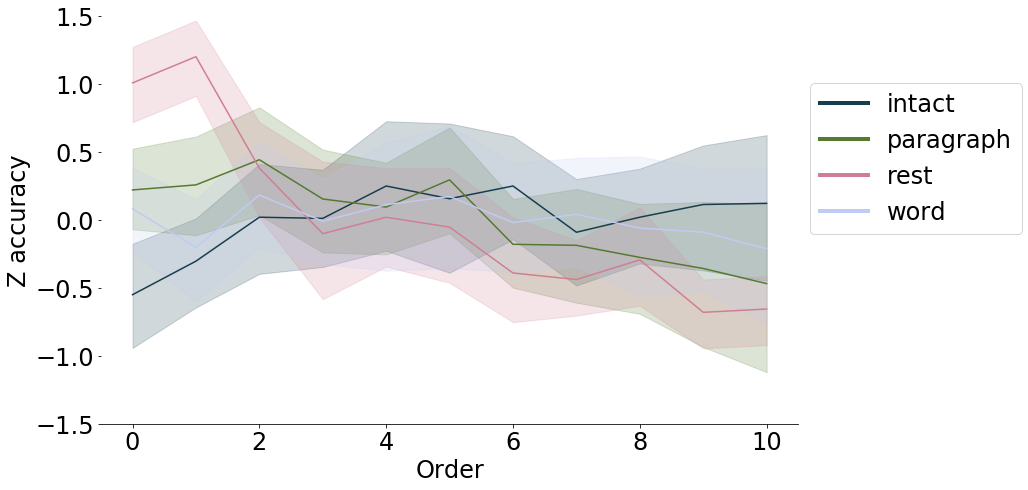

0.2461666666666667
0
isfc PCA laplace 50


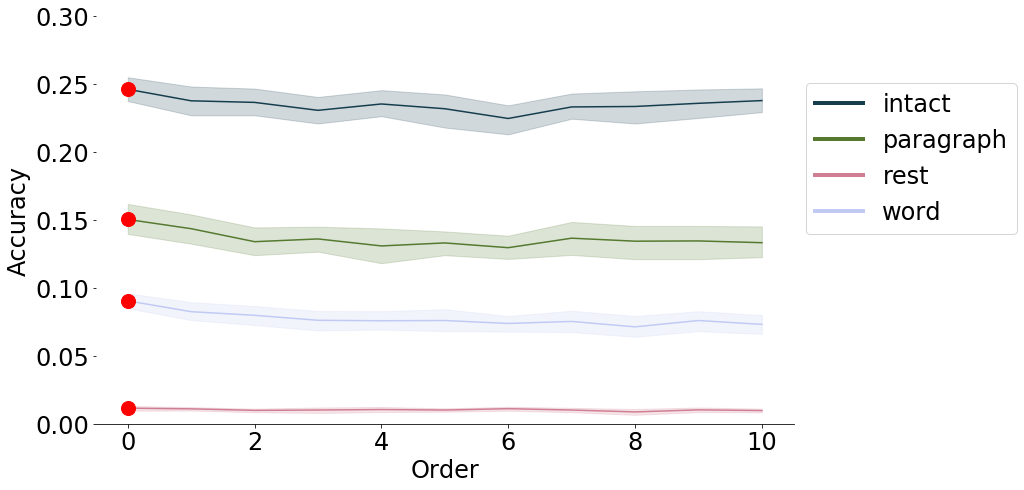

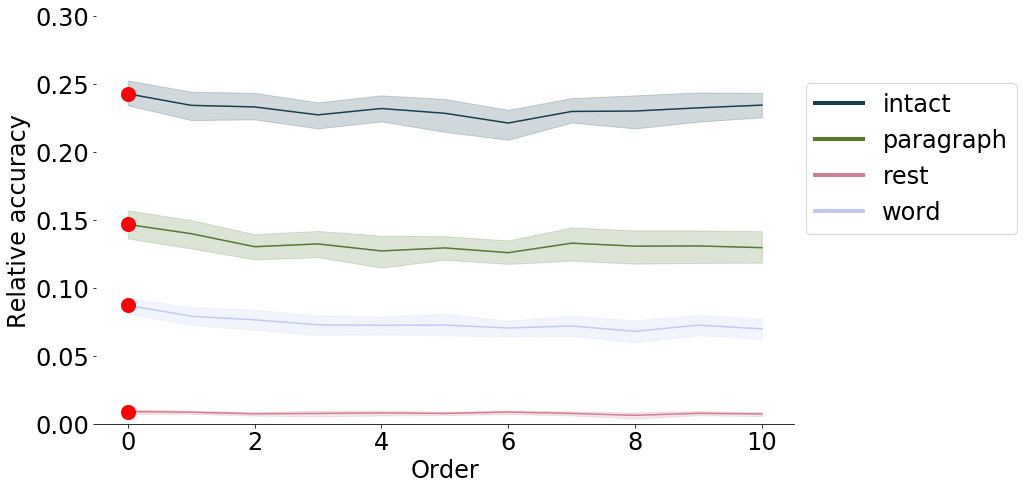

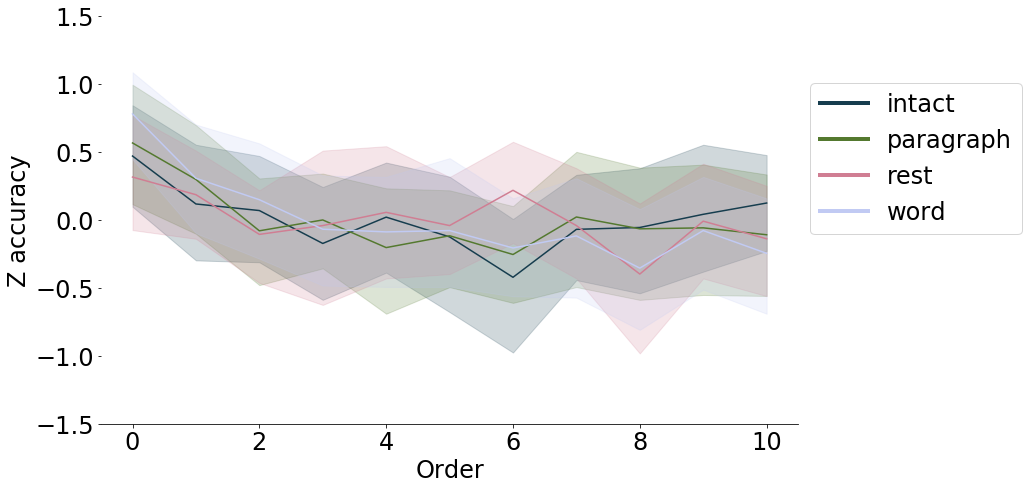

0.25816666666666677
10
isfc PCA hat 10


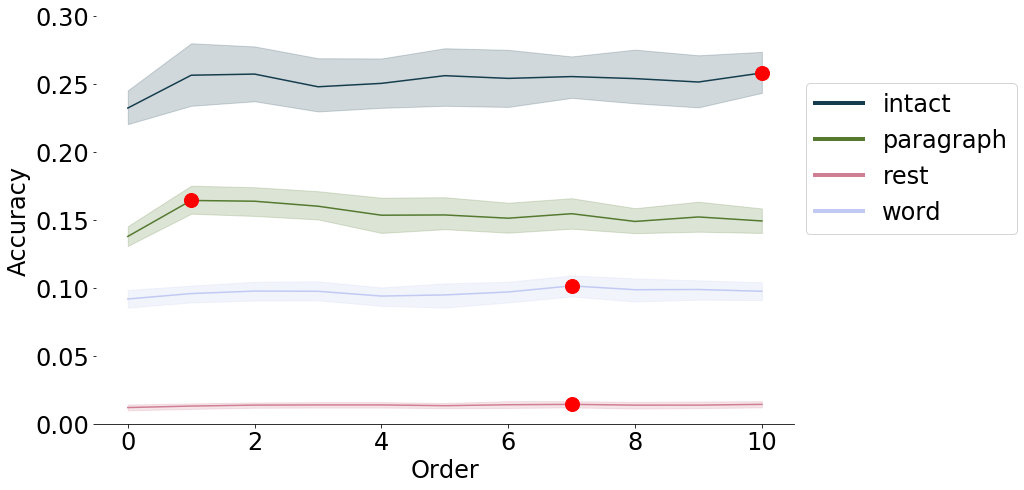

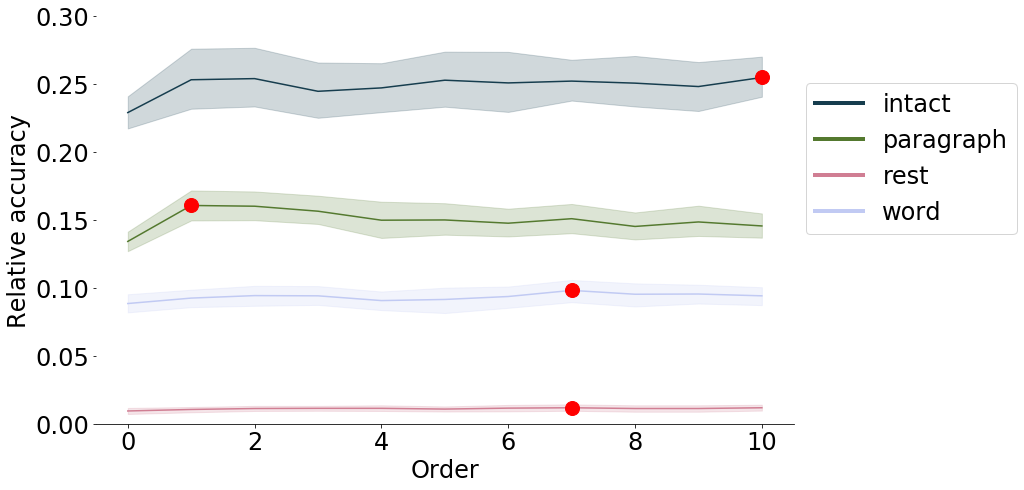

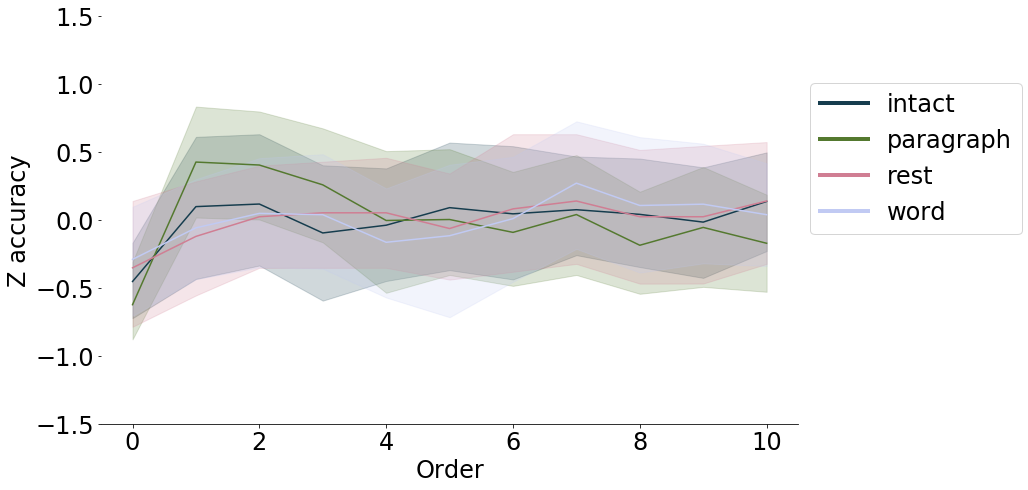

0.28185185185185185
1
isfc PCA hat 20


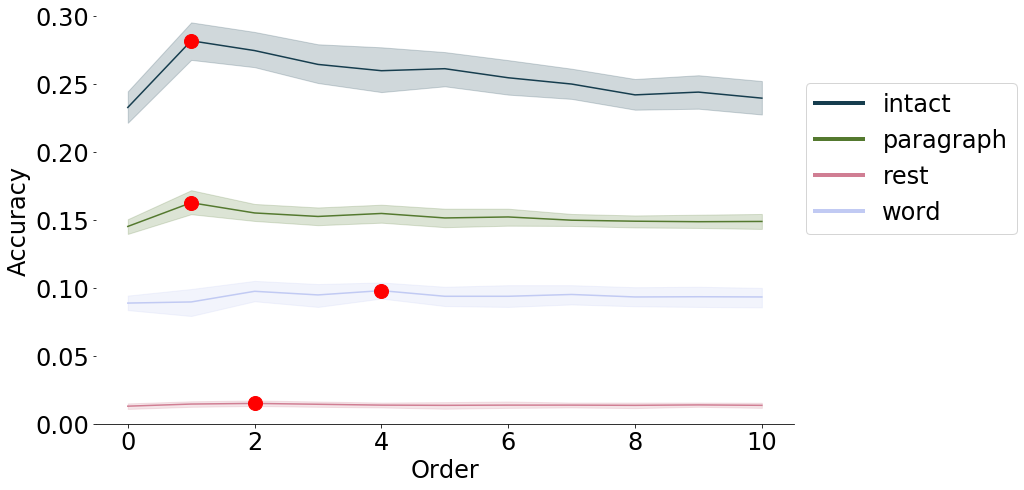

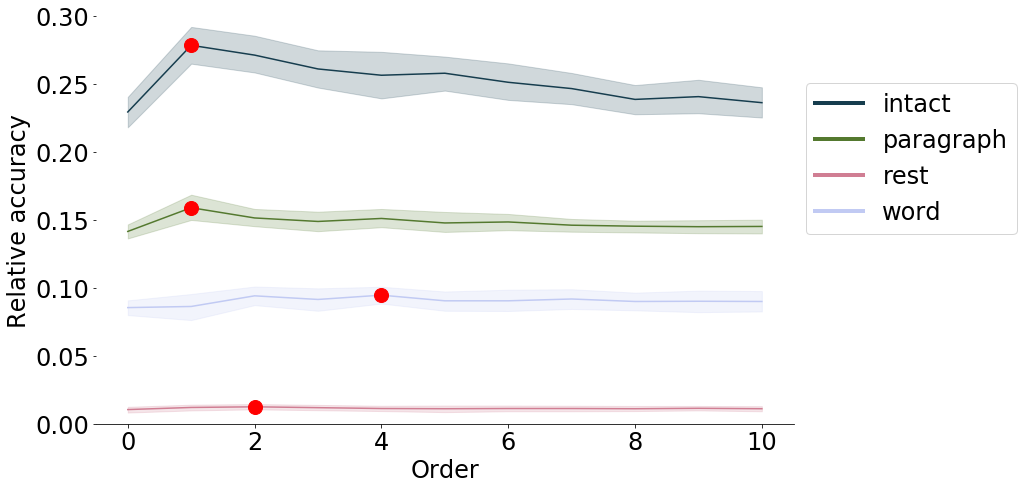

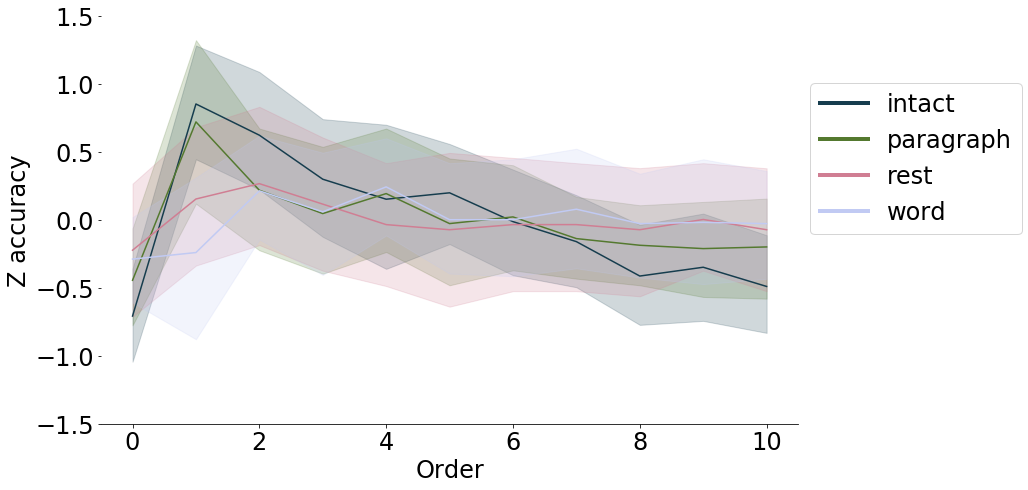

0.26383333333333325
2
isfc PCA hat 5


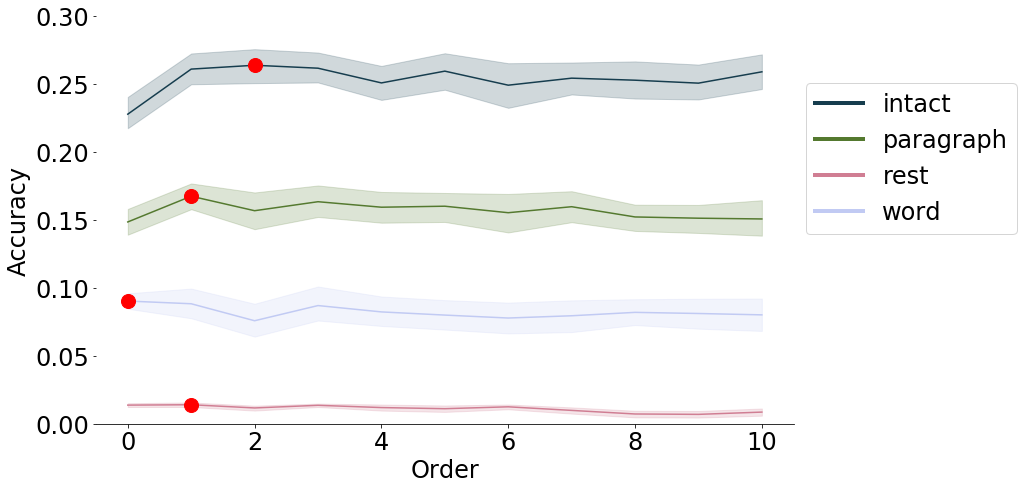

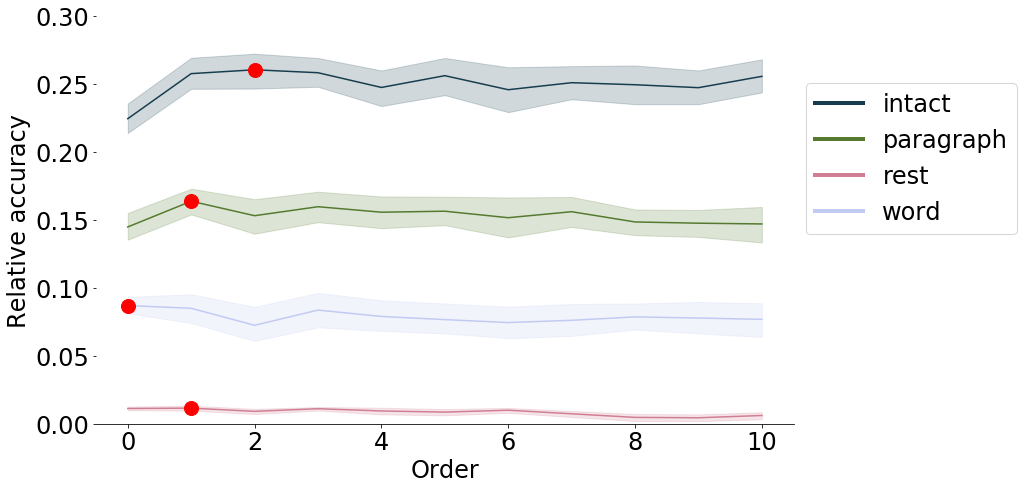

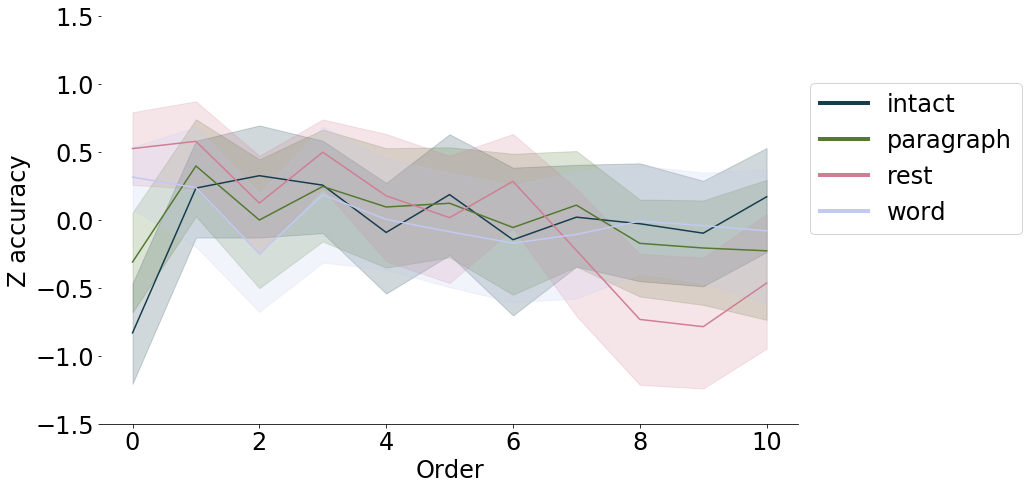

0.2511111111111111
2
isfc PCA hat 50


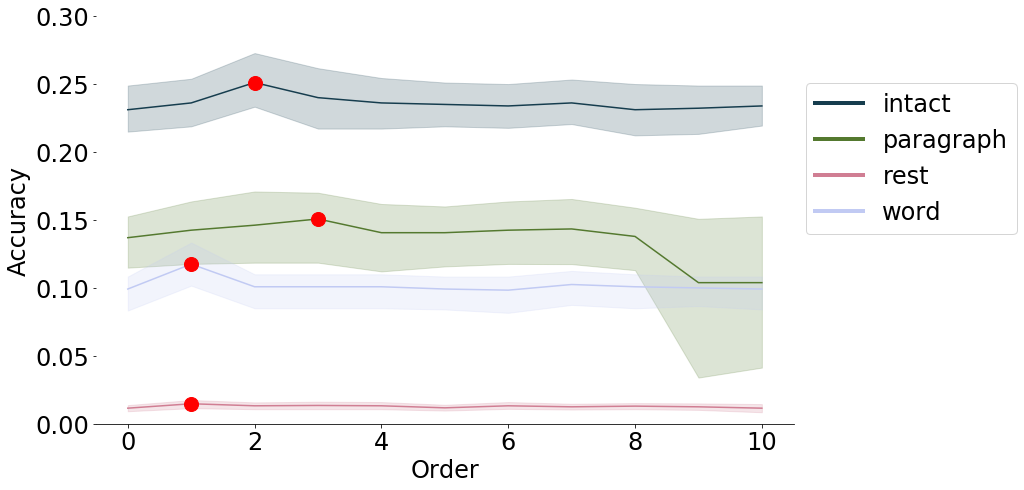

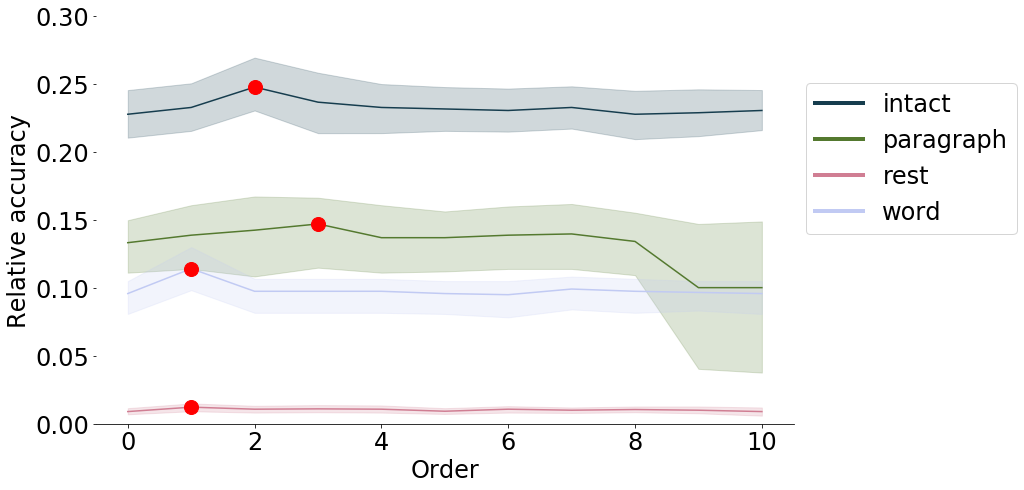

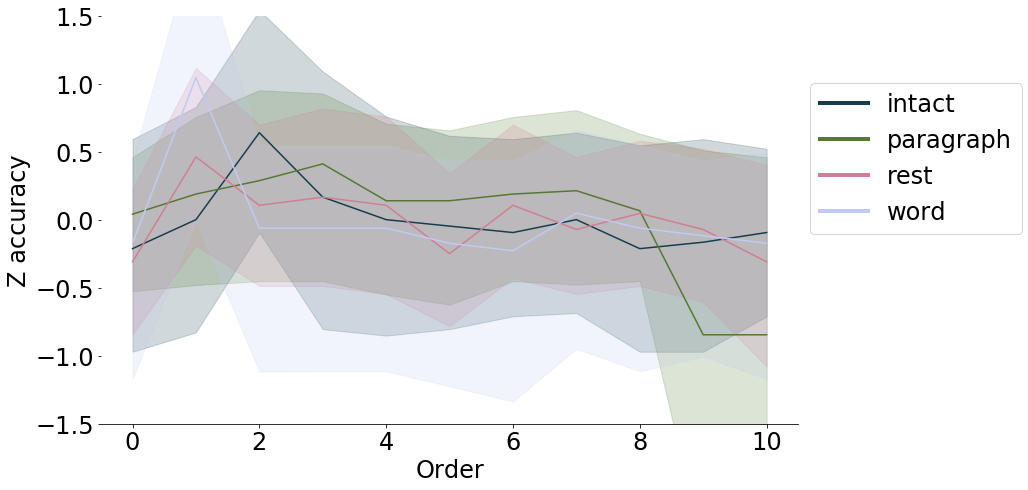

In [25]:

for p in pieman_params:
    param_name = os.path.basename(os.path.splitext(p)[0])

    conds =glob.glob(os.path.join(p, '*.csv'))

    full_data = pd.DataFrame()
    for c in conds:
        
        cond_name = os.path.basename(os.path.splitext(c)[0])
        chance = 1/300      
        if cond_name == 'paragraph':
            chance = 1/272
        elif cond_name == 'rest':
            chance = 1/400
        
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0])
        data['Relative accuracy'] = data['accuracy'] - chance
        data['Normalized accuracy']= data['accuracy'] - np.min(data.groupby('level')['accuracy'].mean())
        data['Normalized accuracy'] = data['Normalized accuracy'] / np.max(data.groupby('level')['Normalized accuracy'].mean())
        data['Z accuracy']= (data['accuracy'] - data['accuracy'].mean())/data['accuracy'].std()
        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    full_data = full_data.rename(index=str, columns={"level": "Level", "accuracy": "Accuracy", "condition": "Condition"})
    
    p_df = full_data[full_data['Condition']=='intact']
    max_level = p_df.groupby('Level').mean()['Accuracy']
    print(max_level[max_level.argmax()])
    print(max_level.argmax())
    
    p_split = param_name.split('_')

    title = p_split[0] + ' ' + p_split[1] + ' ' + p_split[-2] + ' ' + p_split[-1] 
    print(title)
    
    outfile = None
    #outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
    grouped_lineplot(full_data, 'Level', 'Accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = '', outfile=outfile)
    plt.show()
    plt.close()
    
    #outfile = os.path.join(figdir, param_name + '_relative_line_'+ analysis_name + '.pdf')
    grouped_lineplot(full_data, 'Level', 'Relative accuracy','Condition', plot_marker=True, title = '', ymin=0, ymax=.3, outfile=outfile)
    plt.show()
    plt.close()
    
    #outfile = os.path.join(figdir, param_name + '_z_line_'+ analysis_name + '.pdf')
    grouped_lineplot(full_data, 'Level', 'Z accuracy','Condition', title = '', ymin=-1.5, ymax=1.5, outfile=outfile)
    plt.show()
    plt.close()

In [26]:
#### for individual curves


# for p in params:
#     param_name = os.path.basename(os.path.splitext(p)[0])

#     conds =glob.glob(os.path.join(p, '*.csv'))

#     full_data = pd.DataFrame()
#     for c in conds:
        
#         cond_name = os.path.basename(os.path.splitext(c)[0])
#         chance = 1/300      
#         if cond_name == 'paragraph':
#             chance = 1/272
#         elif cond_name == 'rest':
#             chance = 1/400
        
#         data = pd.read_csv(c)
#         data['condition'] = os.path.basename(os.path.splitext(c)[0])
#         #data['level'] = 20 - data.isnull().sum(axis=1)
#         data['Relative accuracy'] = data['accuracy'] - chance
#         data['Normalized accuracy']= data['accuracy'] - np.min(data.groupby('level')['accuracy'].mean())
#         data['Normalized accuracy'] = data['Normalized accuracy'] / np.max(data.groupby('level')['Normalized accuracy'].mean())
        
#         if full_data.empty:
#             full_data = data
#         else:
#             full_data = full_data.append(data)

#     full_data = full_data.rename(index=str, columns={"level": "Level", "accuracy": "Accuracy", "condition": "Condition"})
    
#     p_df = full_data[full_data['Condition']=='intact']
#     max_level = p_df.groupby('Level').mean()['Accuracy']
#     print(max_level[max_level.argmax()])
#     print(max_level.argmax())
    
#     p_split = param_name.split('_')

#     title = p_split[0] + ' ' + p_split[1] + ' ' + p_split[-2] + ' ' + p_split[-1] 
#     print(title)
    
#     outfile = os.path.join(figdir, param_name + '_line_'+ analysis_name + '.pdf')
#     grouped_lineplot(full_data, 'Level', 'Accuracy','Condition', plot_marker=True, ymin=0, ymax=.3, title = '', outfile=outfile)
#     plt.show()
#     plt.close()
    
#     outfile = os.path.join(figdir, param_name + '_relative_line_'+ analysis_name + '.pdf')
#     grouped_lineplot(full_data, 'Level', 'Relative accuracy','Condition', plot_marker=True, title = '', ymin=0, ymax=.3, outfile=outfile)
#     plt.show()
#     plt.close()
    
#     outfile = os.path.join(figdir, param_name + '_normalized_line_'+ analysis_name + '.pdf')
#     grouped_lineplot(full_data, 'Level', 'Normalized accuracy','Condition', title = '', ymin=0, ymax=1.5, outfile=outfile)
#     plt.show()
#     plt.close()